In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing Libraries

In [ ]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import skimage
import pandas as pd

## Task 1: Image Segmentation and Detection



## A: Object segmentation

In [ ]:
folder_path = "/content/drive/MyDrive/ball_frames/frames_feature_extraction_image_segmentation"

for image_name in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_name)
    image_name_only, _ = os.path.splitext(image_name)
    image = cv2.imread(image_path)
    blur = cv2.GaussianBlur(image, (7,7), 0)
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(blur, kernel, iterations=1)
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    edges = cv2.Canny(dilated, threshold1=0, threshold2=150)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the height of the image
    height = image.shape[0]
    # Calculate the y-coordinate of the middle of the image
    middle_y = (height // 2)-60

    # Create a black image with the same dimensions as the original image
    mask = np.zeros_like(image)

    # Iterate through contours and draw only if centroid is below middle
    for contour in contours:
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # Check if centroid is below middle
            if cY > middle_y:
                cv2.drawContours(mask, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Show the masked image
    masked_image = cv2.bitwise_and(image, mask)

    # Convert the masked image to binary
    _, binary_image = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY)

    cv2.imwrite(f"/content/drive/MyDrive/ball_frames/masked_images/{image_name_only}_masked.png", binary_image)

print("Masked Images Saved to /content/drive/MyDrive/ball_frames/masked_images/")


Masked Images Saved to /content/drive/MyDrive/ball_frames/masked_images/


## B: Segmentation evaluation

In [ ]:
def dice_similarity_score(y_true, y_pred):
    intersection = np.sum((y_true * y_pred))
    return (2. * intersection) / (np.sum(y_true==255) + np.sum(y_pred==255))

In [ ]:
# Ground-truth ball mask folder path
ground_truth_folder = "/content/drive/MyDrive/ball_frames/gt"

# Segmented ball region folder path (output folder from Task 1)
segmented_folder = "/content/drive/MyDrive/ball_frames/masked_images"

# Lists to store DS values and image numbers
ds_values = []
image_numbers = []

In [ ]:
# Sort file names to ensure sequential processing
gt_image_names = sorted(os.listdir(ground_truth_folder))
segmented_image_names = sorted(os.listdir(segmented_folder))

In [ ]:
# Calculate DS for each ball image
for gt_image_name, segmented_image_name in zip(gt_image_names, segmented_image_names):
    gt_image_path = os.path.join(ground_truth_folder, gt_image_name)
    segmented_image_path = os.path.join(segmented_folder, segmented_image_name)

    # Extract image number from ground truth image name
    image_number = int(gt_image_name.split('-')[1].split('.')[0].split('_')[0])

    # Read the ground truth and segmented images
    ground_truth_image = cv2.imread(gt_image_path, cv2.IMREAD_GRAYSCALE)
    segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)

    # Compute the Dice Similarity Score (DS)
    ds = dice_similarity_score(ground_truth_image, segmented_image)

    print("DS Score between",gt_image_name,segmented_image_name,":",ds)

    # Append DS value and image number to lists
    ds_values.append(ds)
    image_numbers.append(image_number)

DS Score between frame-100_GT.png frame-100_masked.png : 0.6334140435835351
DS Score between frame-101_GT.png frame-101_masked.png : 0.767967967967968
DS Score between frame-102_GT.png frame-102_masked.png : 0.7348892878515859
DS Score between frame-103_GT.png frame-103_masked.png : 0.8126990650364738
DS Score between frame-104_GT.png frame-104_masked.png : 0.7315803643543032
DS Score between frame-105_GT.png frame-105_masked.png : 0.8091741455897018
DS Score between frame-106_GT.png frame-106_masked.png : 0.7935432087755284
DS Score between frame-107_GT.png frame-107_masked.png : 0.8287671232876712
DS Score between frame-108_GT.png frame-108_masked.png : 0.7663133487909904
DS Score between frame-109_GT.png frame-109_masked.png : 0.8003267380649846
DS Score between frame-110_GT.png frame-110_masked.png : 0.9895655473344717
DS Score between frame-111_GT.png frame-111_masked.png : 1.0286731634182908
DS Score between frame-112_GT.png frame-112_masked.png : 0.9433760683760684
DS Score betw

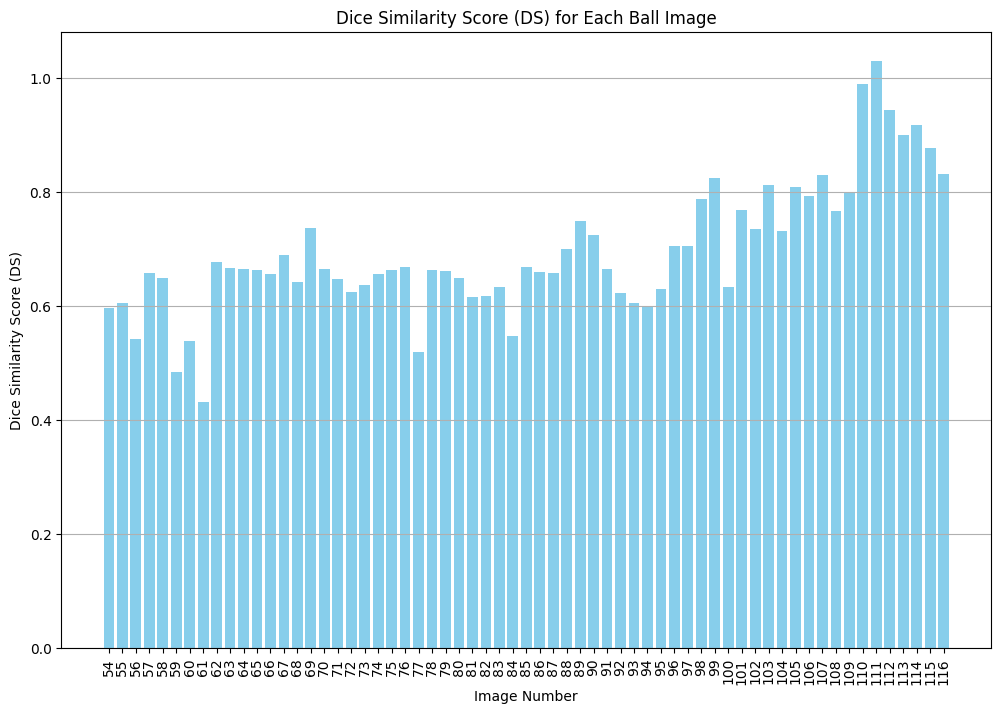

Mean DS: 0.695736042671282
Standard Deviation of DS: 0.11445797751056472

Best 5 Segmented Ball Images:
Image Number: 111, DS: 1.0286731634182908
Image Number: 110, DS: 0.9895655473344717
Image Number: 112, DS: 0.9433760683760684
Image Number: 114, DS: 0.9165511053103842
Image Number: 113, DS: 0.8999536393138619

Worst 5 Segmented Ball Images:
Image Number: 56, DS: 0.5413859079943433
Image Number: 60, DS: 0.5376392483402723
Image Number: 77, DS: 0.5196725039799863
Image Number: 59, DS: 0.48376438418594053
Image Number: 61, DS: 0.432


In [ ]:
# Plot bar graph
plt.figure(figsize=(12, 8))
plt.bar(image_numbers, ds_values, color='skyblue')
plt.xlabel('Image Number')
plt.ylabel('Dice Similarity Score (DS)')
plt.title('Dice Similarity Score (DS) for Each Ball Image')
plt.xticks(image_numbers,rotation='vertical')
plt.grid(axis='y')
plt.show()

# Calculate mean and standard deviation of DS
mean_ds = np.mean(ds_values)
std_dev_ds = np.std(ds_values)

print("Mean DS:", mean_ds)
print("Standard Deviation of DS:", std_dev_ds)

# Sort DS values and corresponding image numbers
sorted_ds_image_pairs = sorted(zip(ds_values, image_numbers), reverse=True)

# Best 5 segmented ball images
print("\nBest 5 Segmented Ball Images:")
for ds, image_number in sorted_ds_image_pairs[:5]:
    print(f"Image Number: {image_number}, DS: {ds}")

# Worst 5 segmented ball images
print("\nWorst 5 Segmented Ball Images:")
for ds, image_number in sorted_ds_image_pairs[-5:]:
    print(f"Image Number: {image_number}, DS: {ds}")

## Task 2: Task 2: Feature Calculation

## A: Shape Features

In [ ]:
def calculate_shape_features(contour):
    # Calculate contour of the object
    # Calculate area
    area = cv2.contourArea(contour)

    # Calculate perimeter
    perimeter = cv2.arcLength(contour, closed=True)

    # Calculate solidity
    solidity = area / perimeter**2

    # Calculate non-compactness
    non_compactness = perimeter**2 / (4 * np.pi * area)

    # Calculate circularity
    circularity = (4 * np.pi * area) / perimeter**2

    # Calculate eccentricity
    ellipse = cv2.fitEllipse(contour)
    (xc, yc), (d1, d2), angle = ellipse
    eccentricity = np.sqrt(1 - (d1**2 / d2**2))

    return solidity, non_compactness, circularity, eccentricity

In [ ]:
# Load original RGB images
# Directory paths
rgb_images_dir = '/content/drive/MyDrive/ball_frames/frames_feature_extraction_image_segmentation'
gt_masks_dir = '/content/drive/MyDrive/ball_frames/gt'

# Get full file paths for RGB images
rgb_image_paths = [os.path.join(rgb_images_dir, filename) for filename in sorted(os.listdir(rgb_images_dir))]

# Get full file paths for ground truth masks
gt_mask_paths = [os.path.join(gt_masks_dir, filename) for filename in sorted(os.listdir(gt_masks_dir))]

# Load original RGB images
rgb_images = [cv2.imread(path) for path in rgb_image_paths]

# Load ground truth ball masks
gt_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in gt_mask_paths]

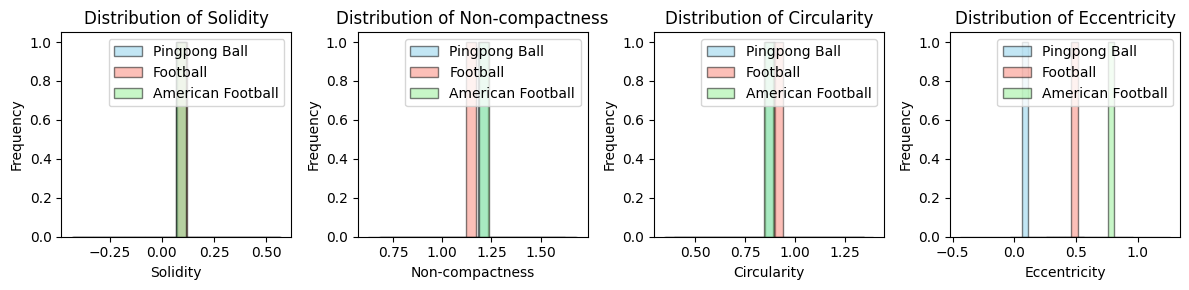

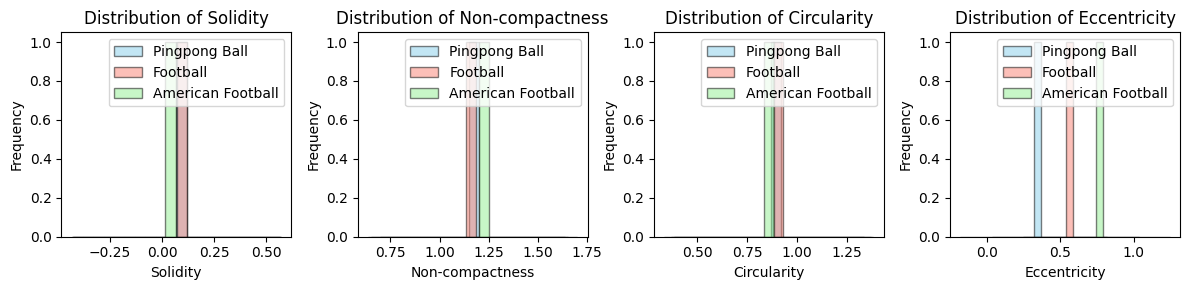

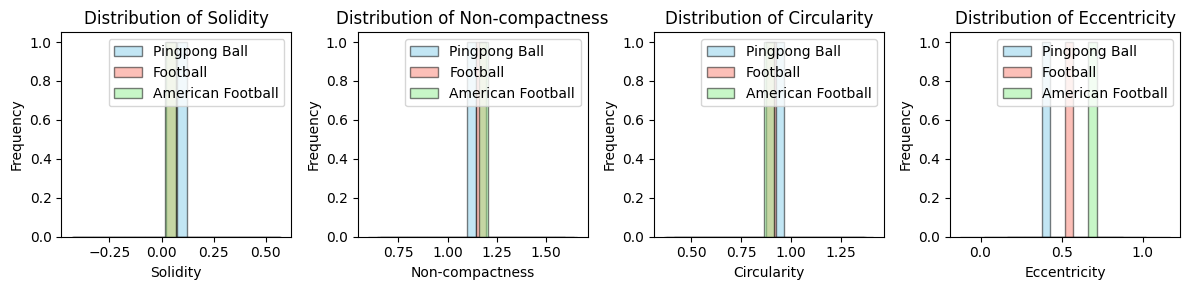

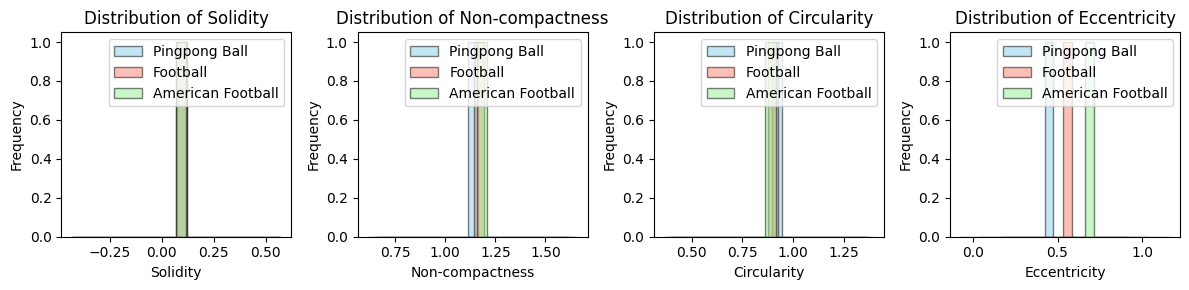

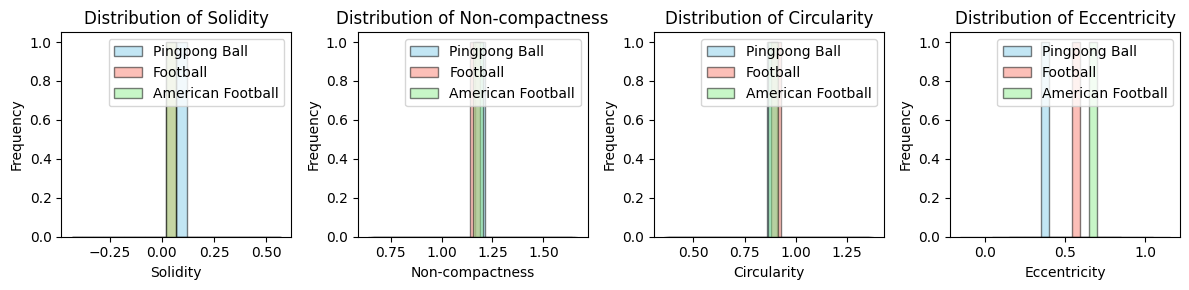

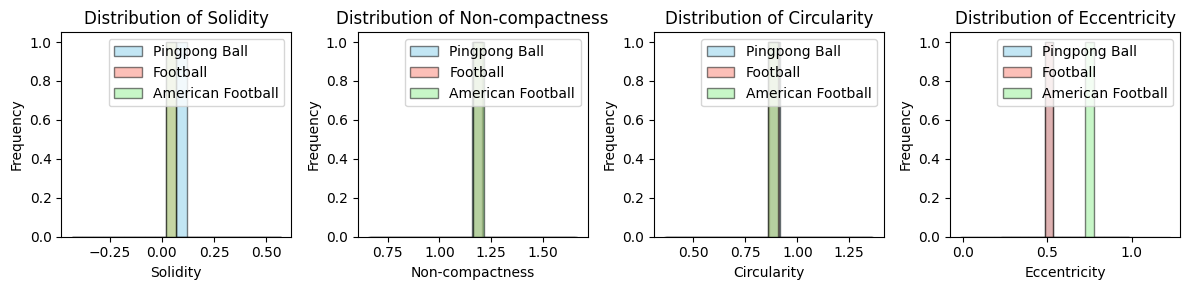

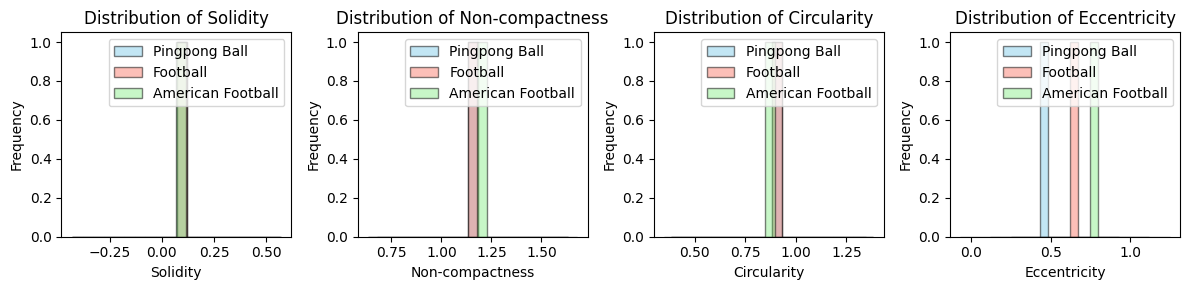

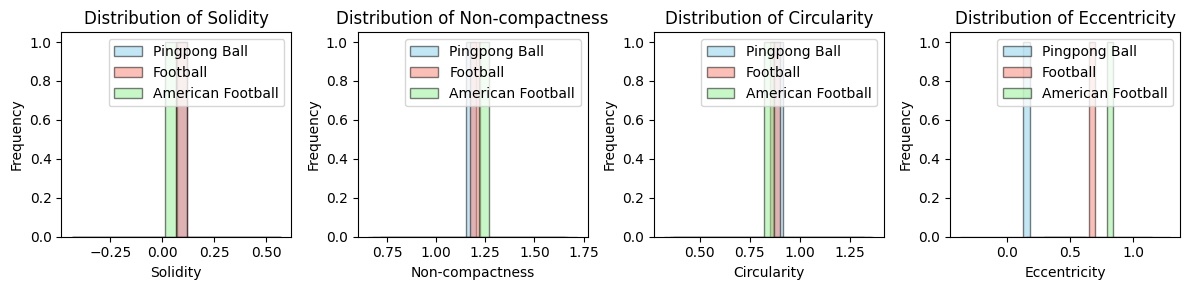

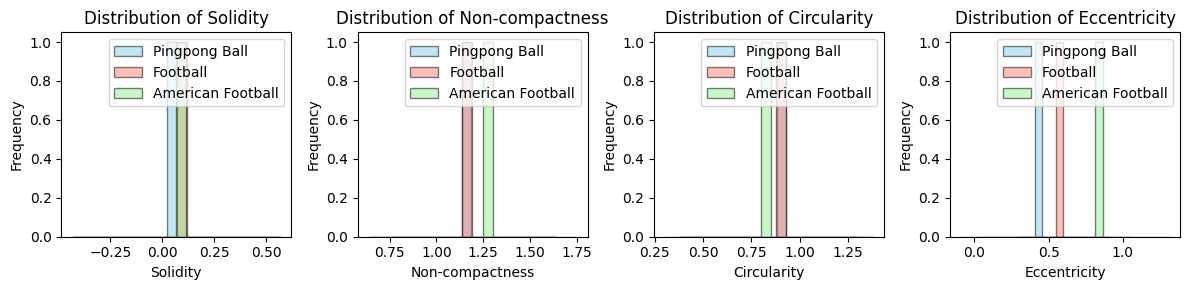

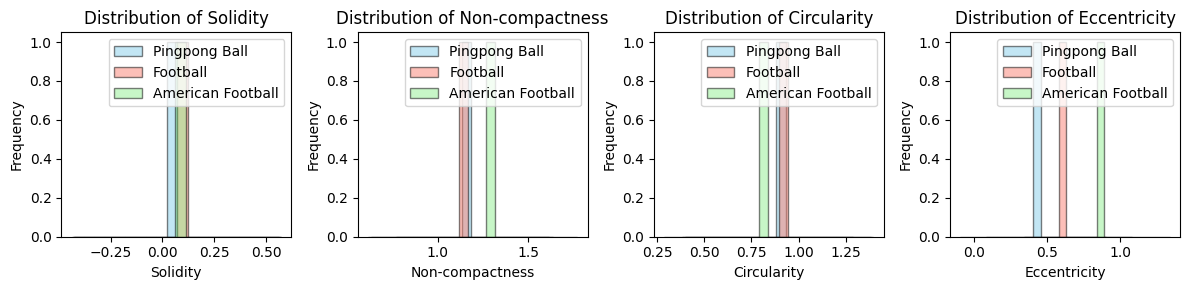

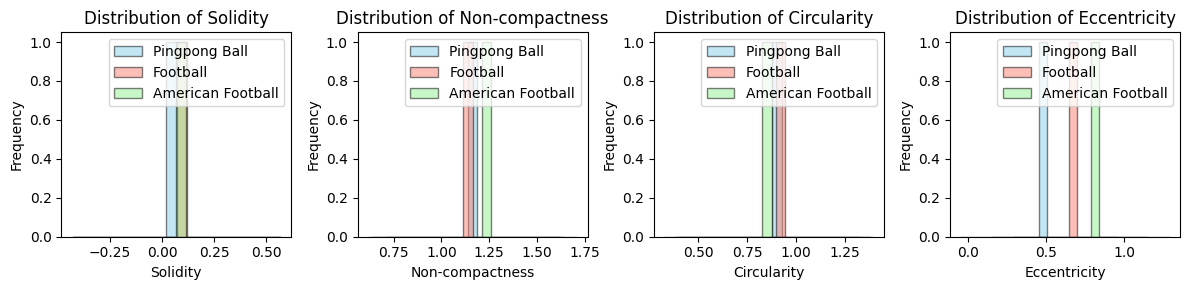

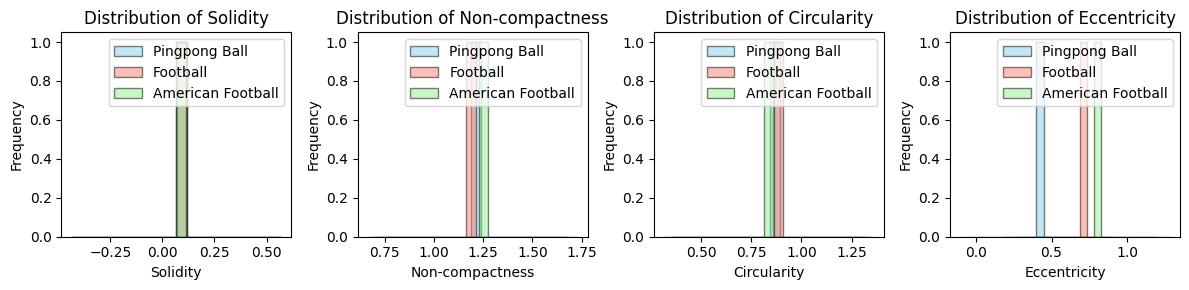

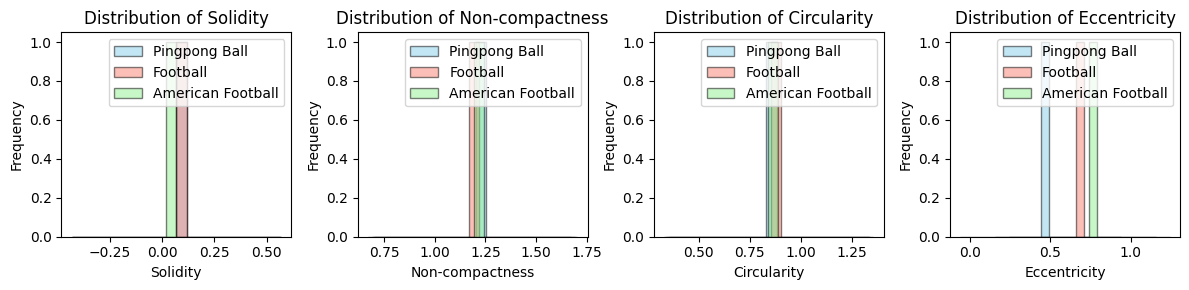

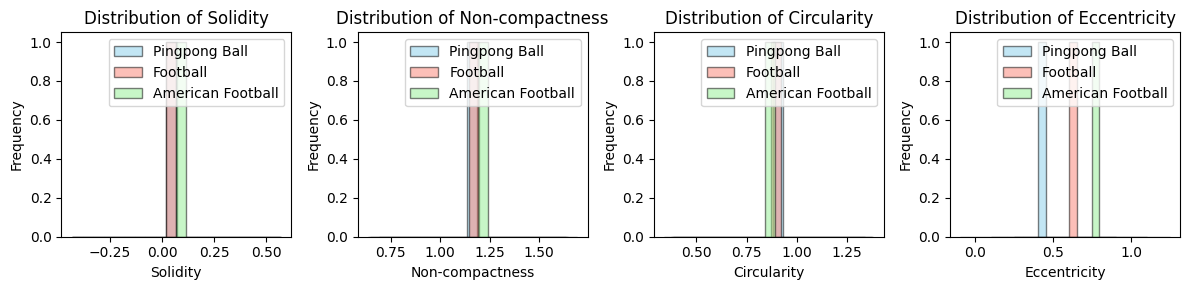

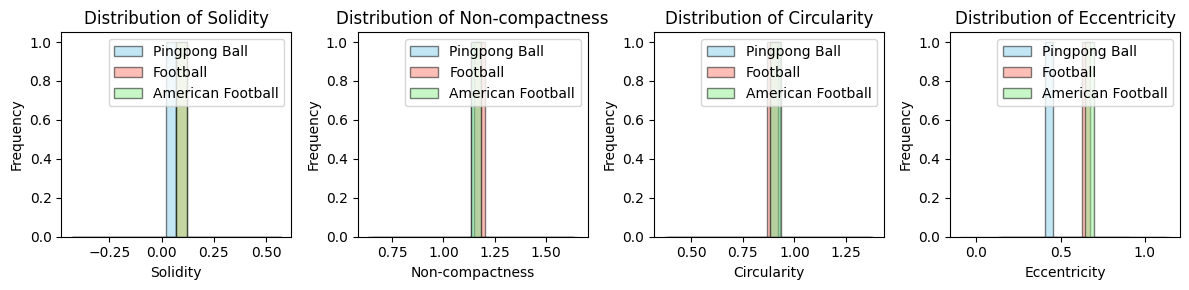

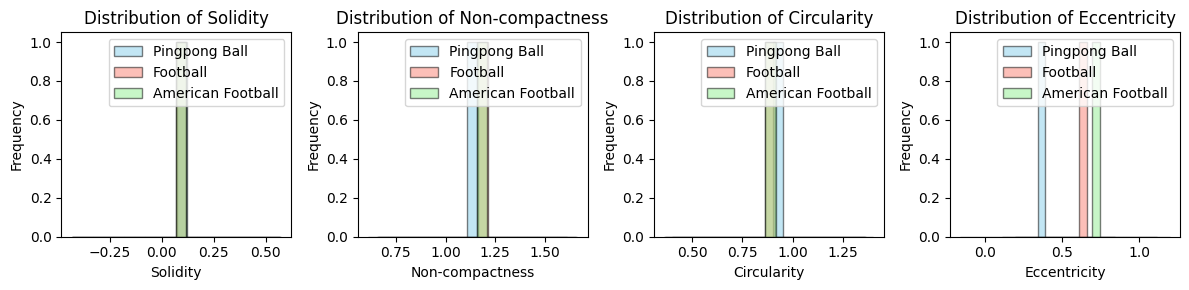

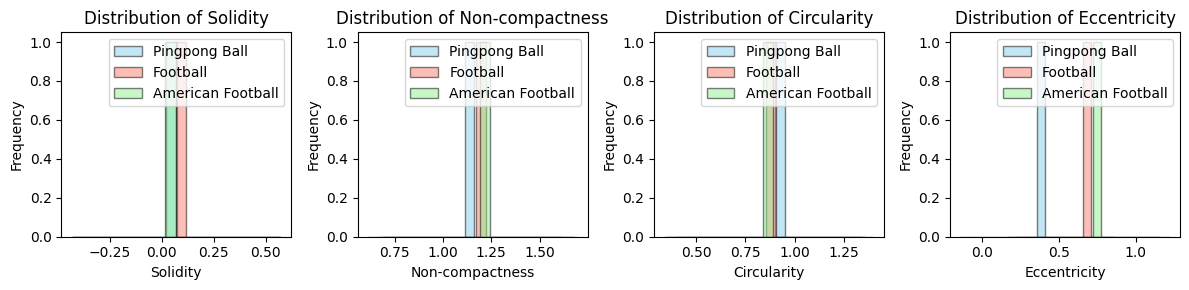

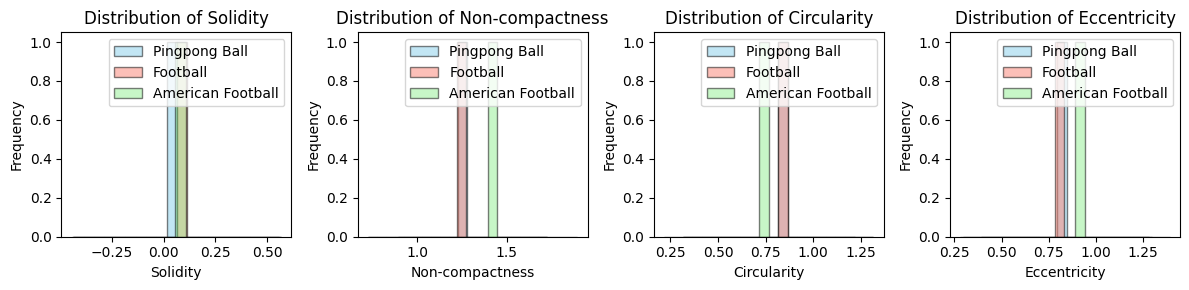

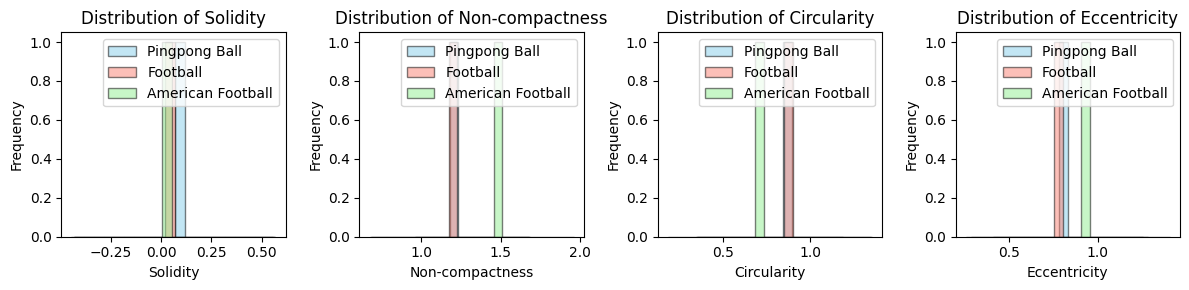

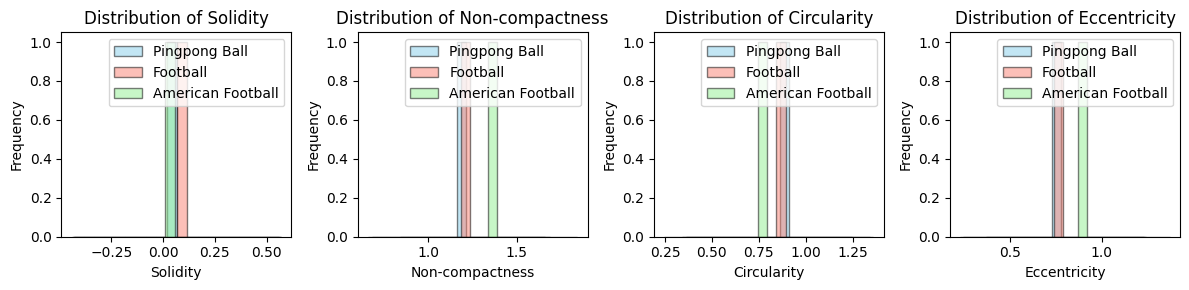

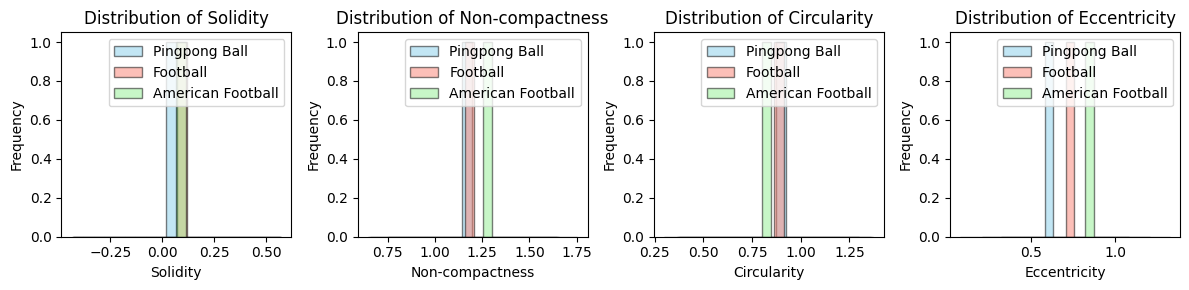

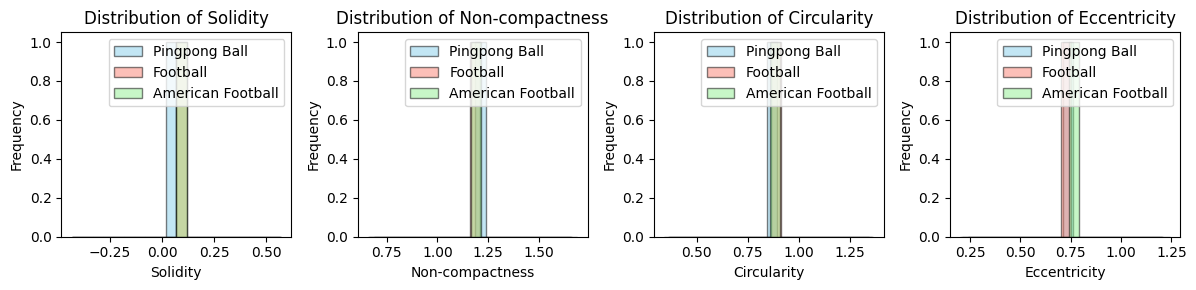

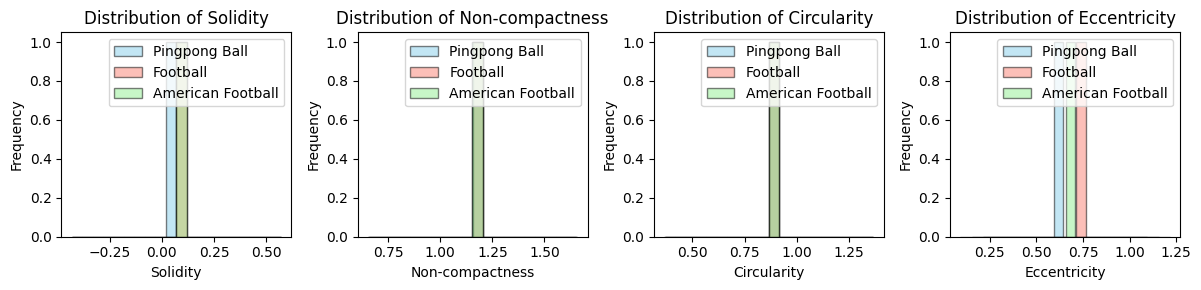

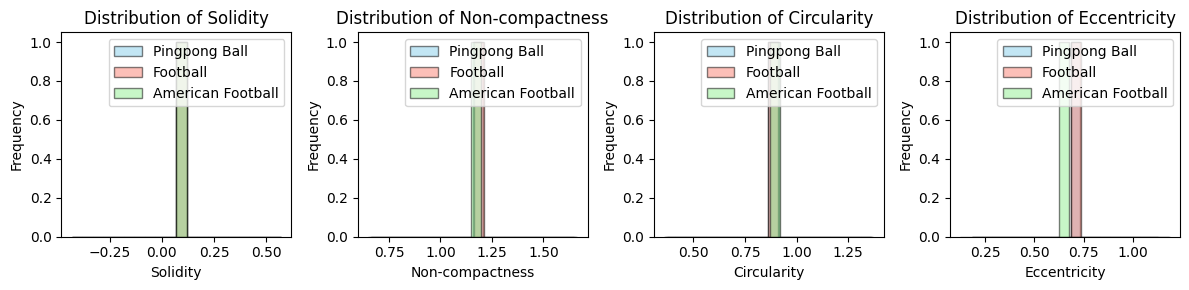

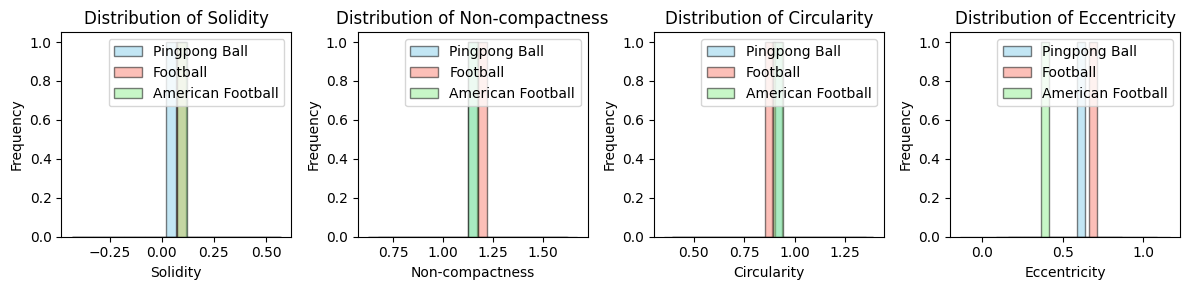

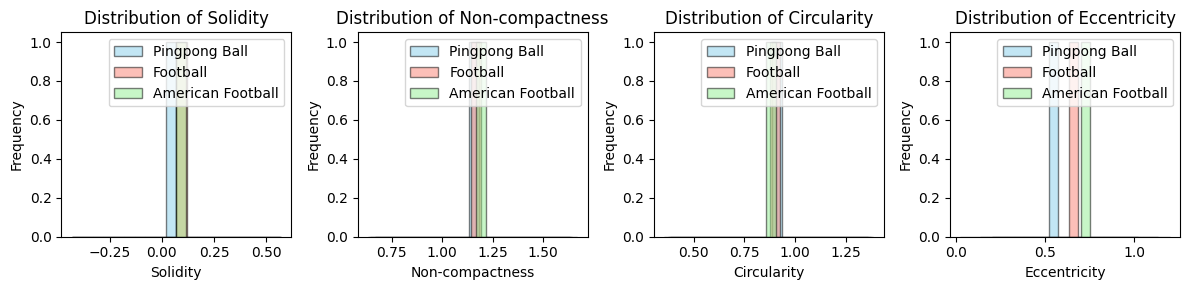

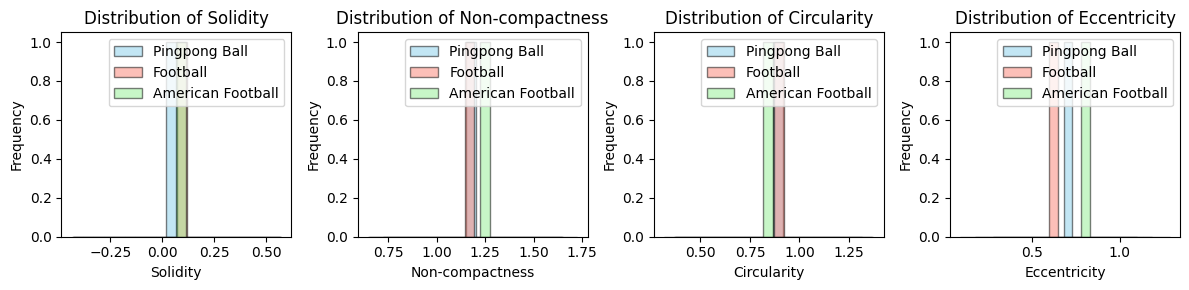

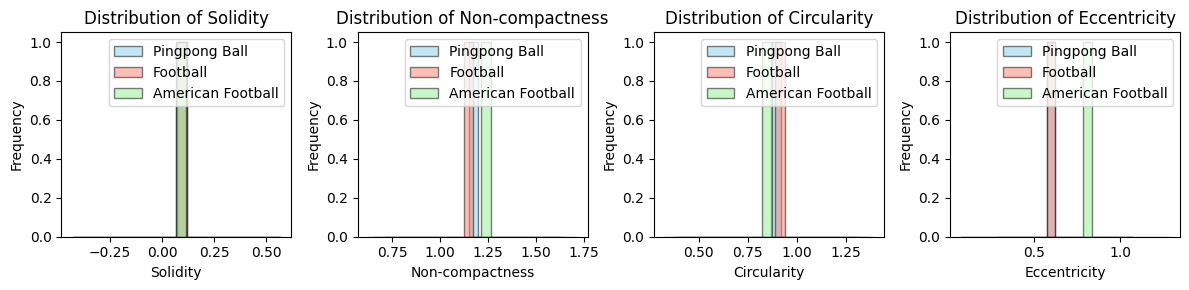

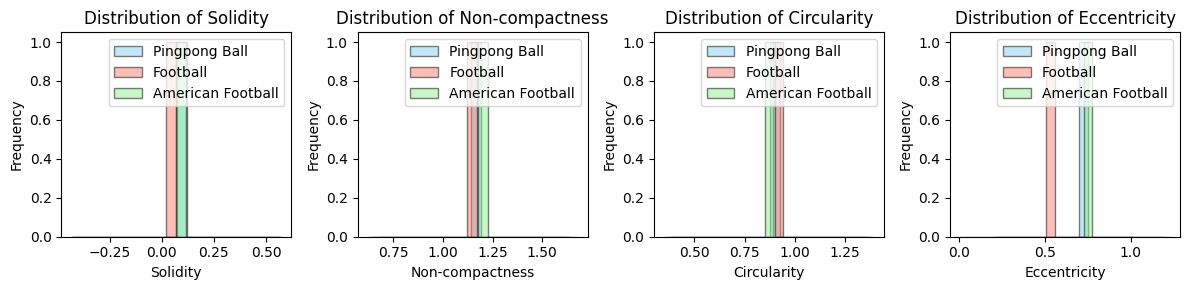

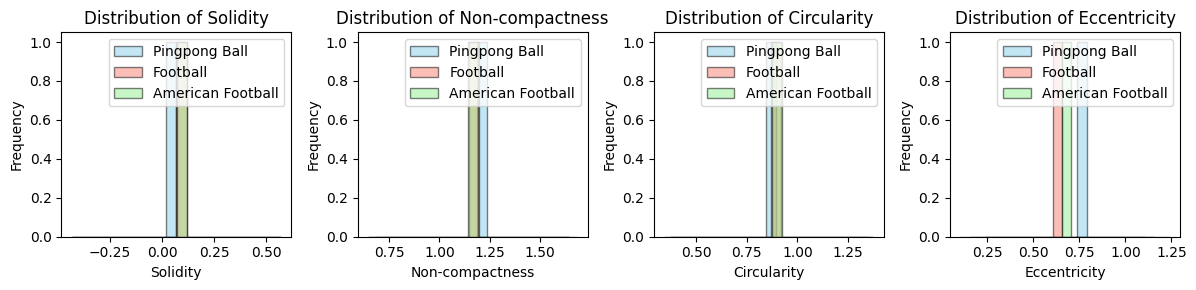

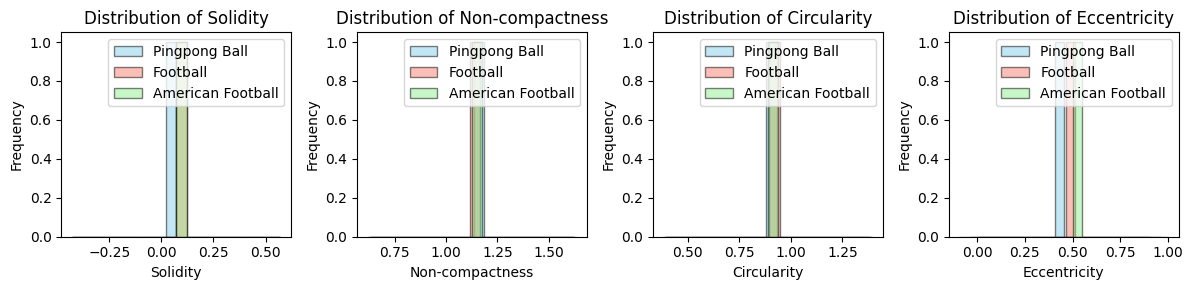

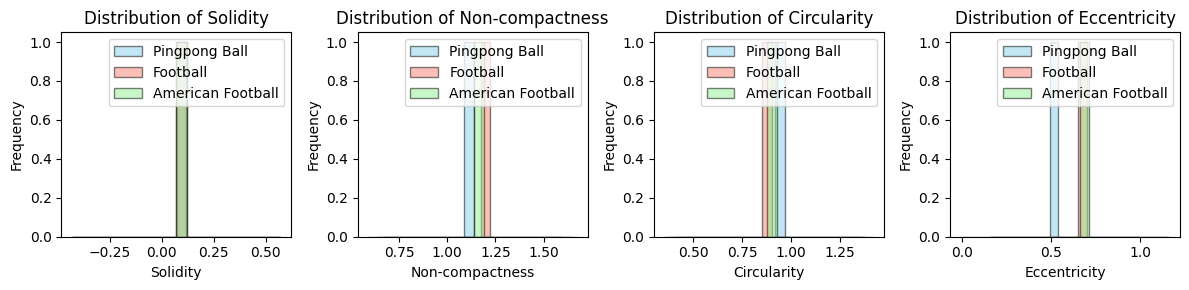

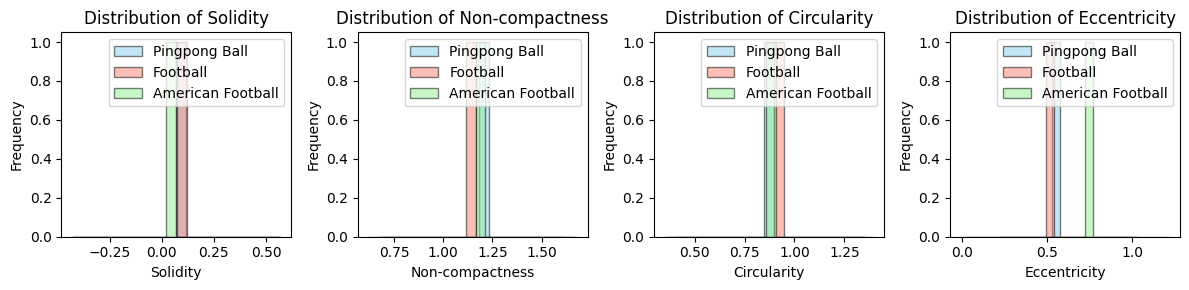

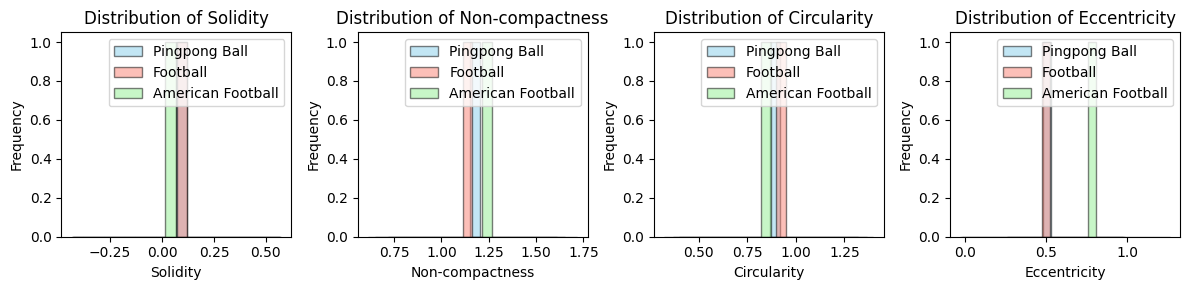

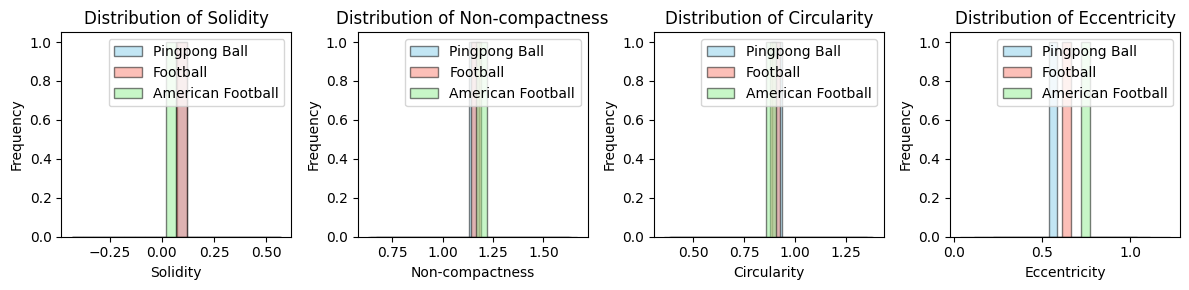

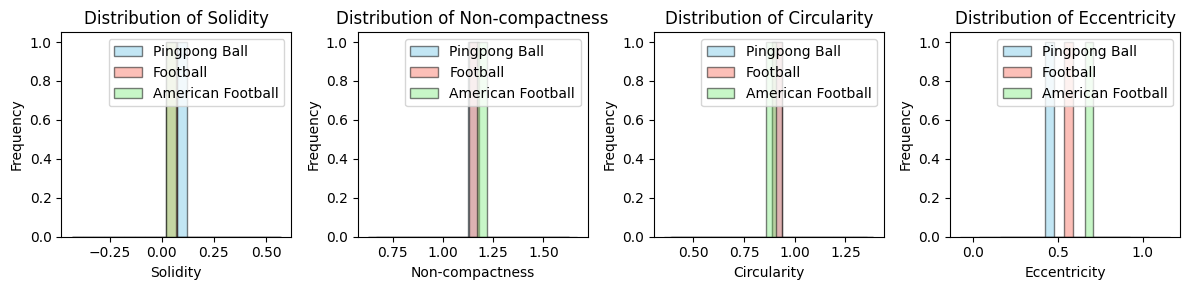

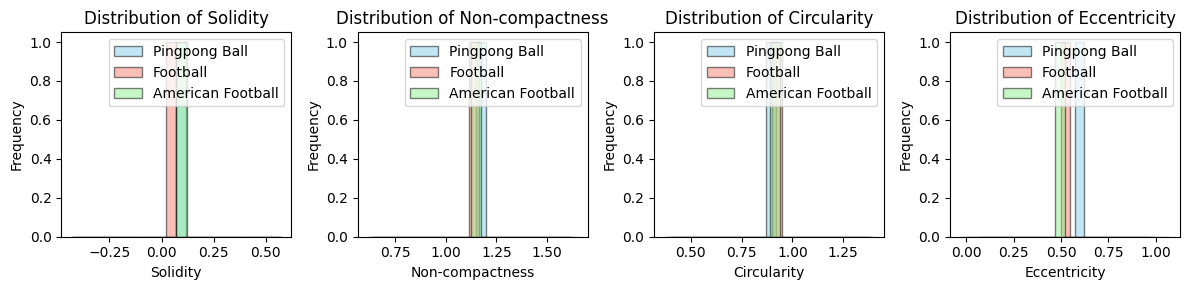

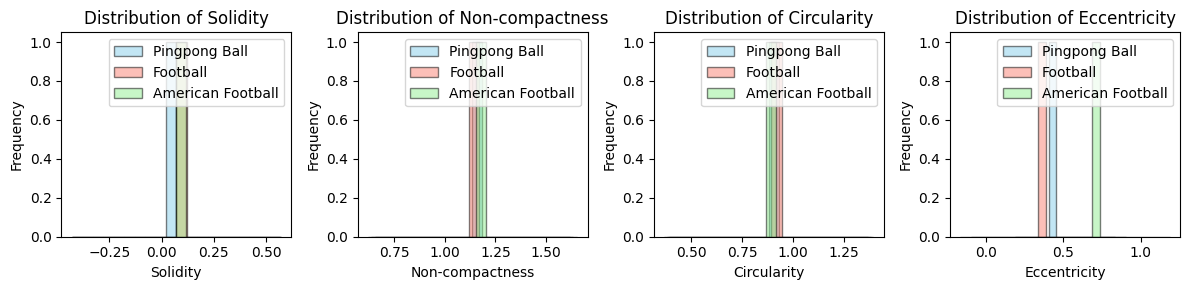

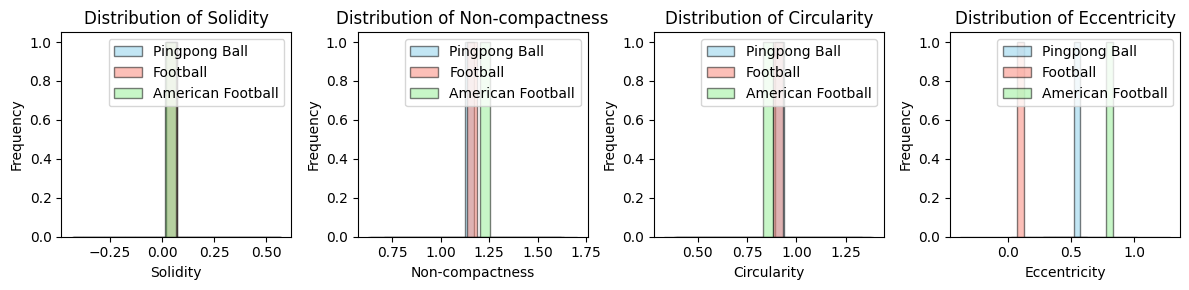

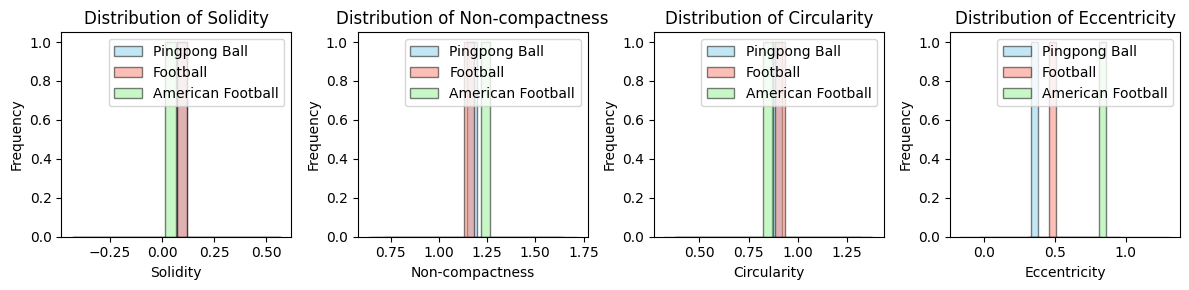

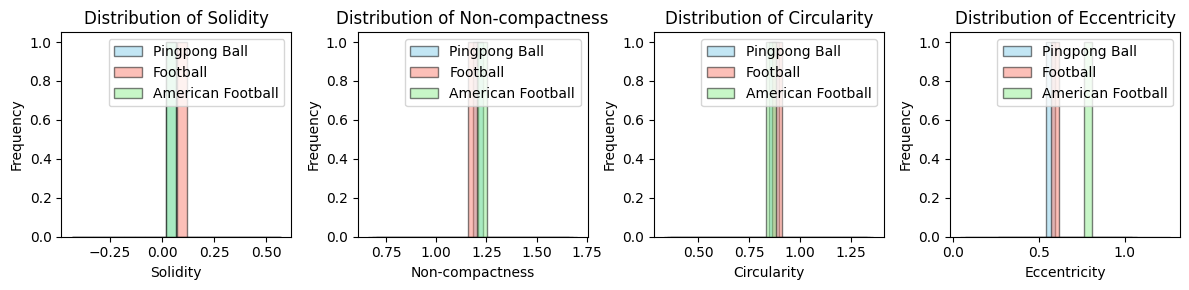

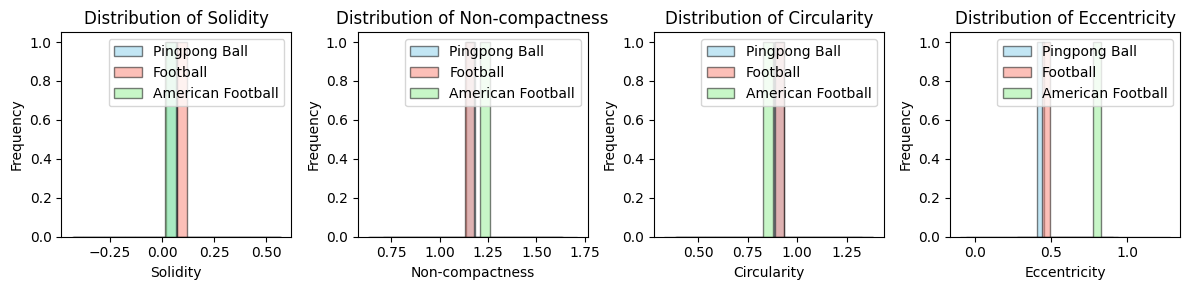

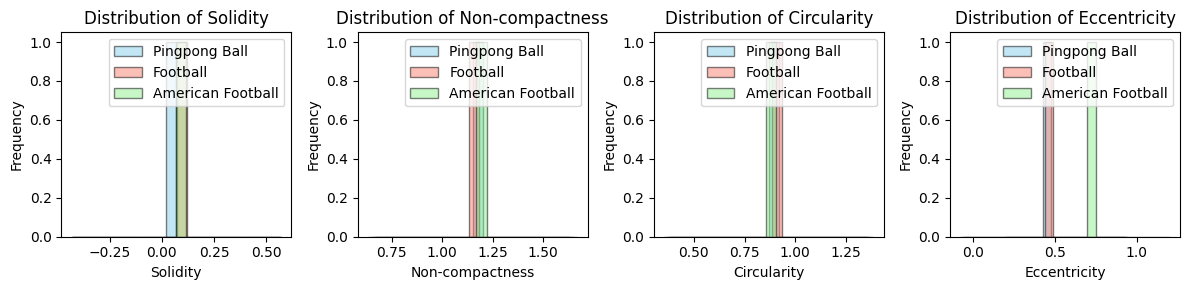

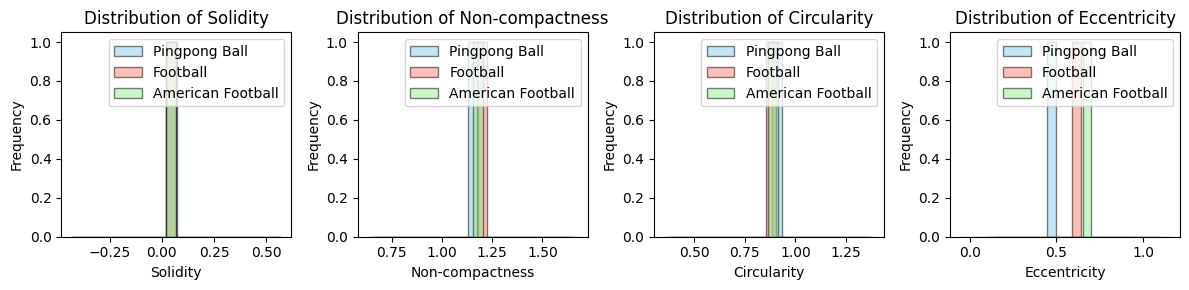

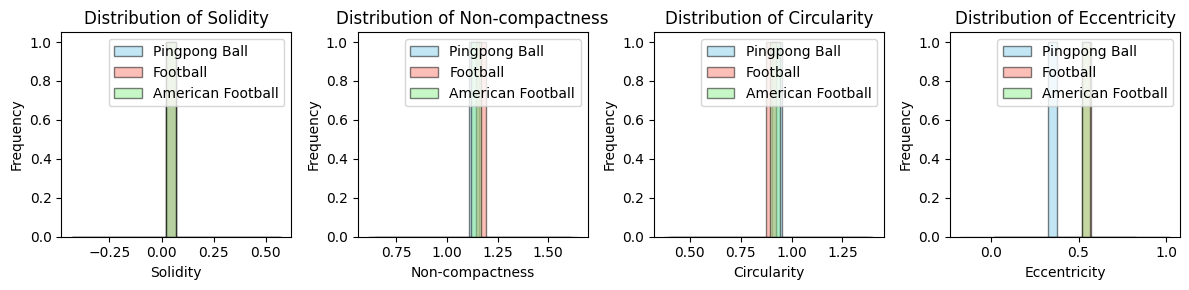

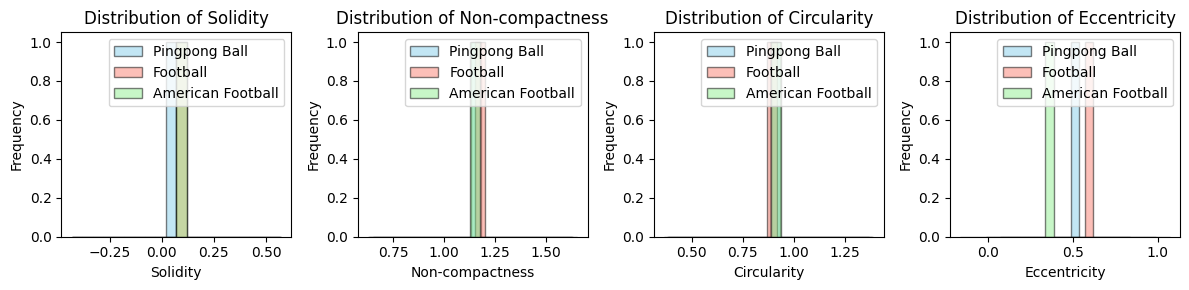

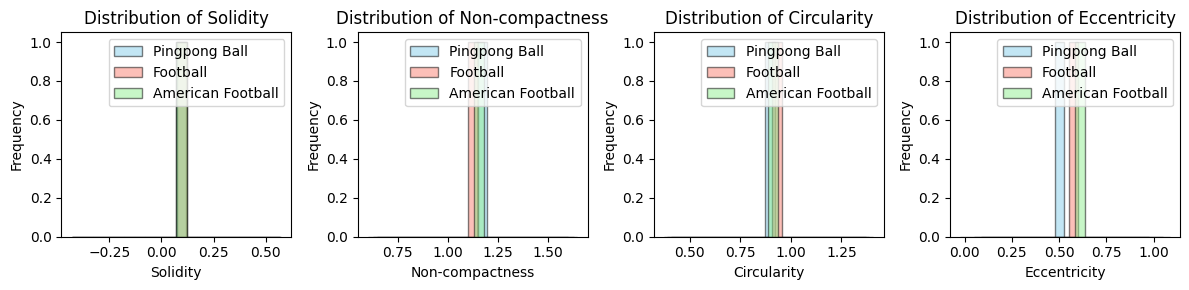

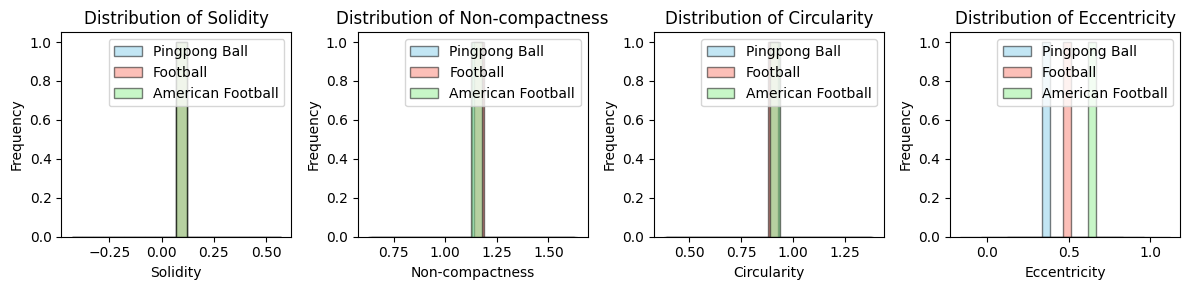

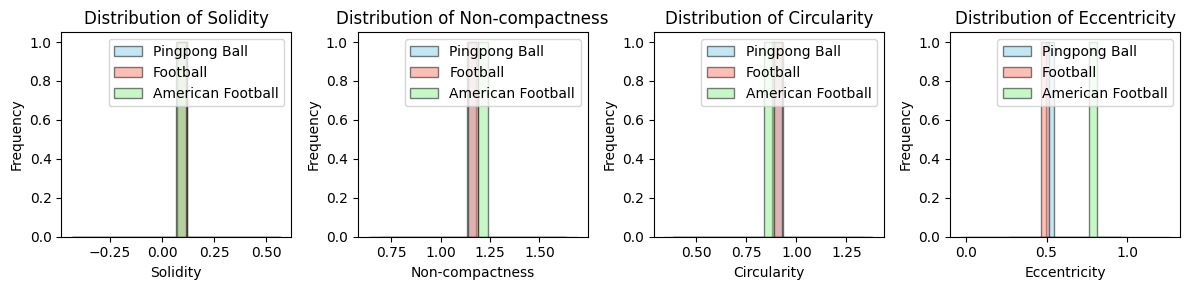

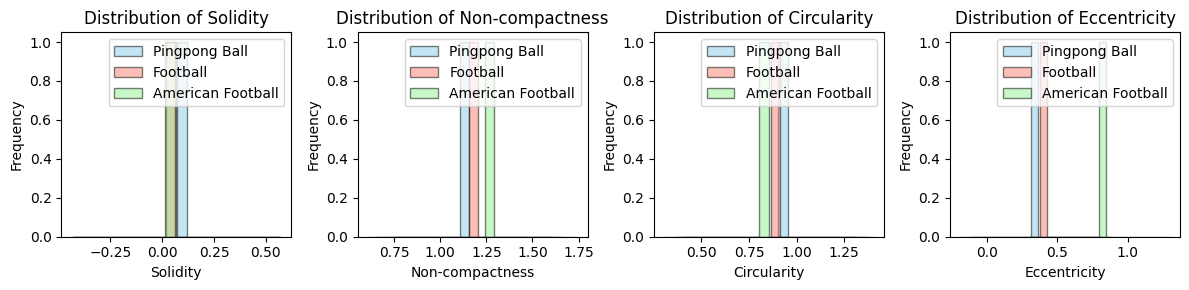

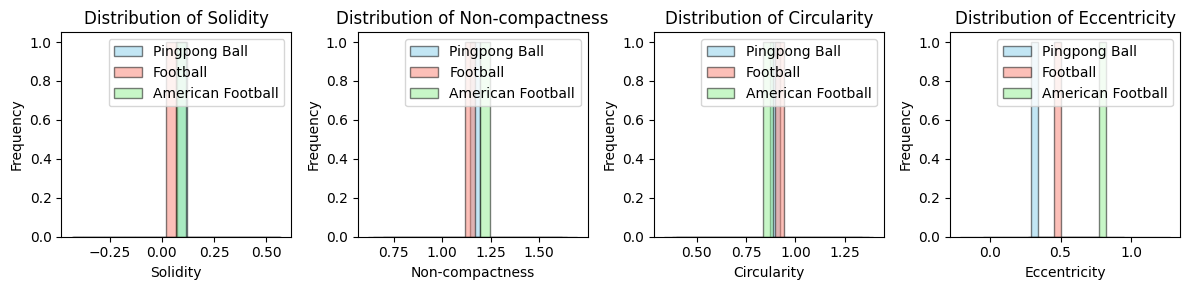

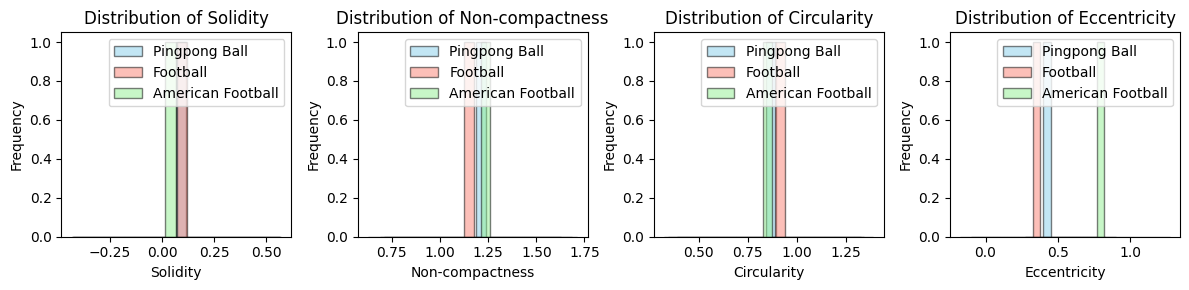

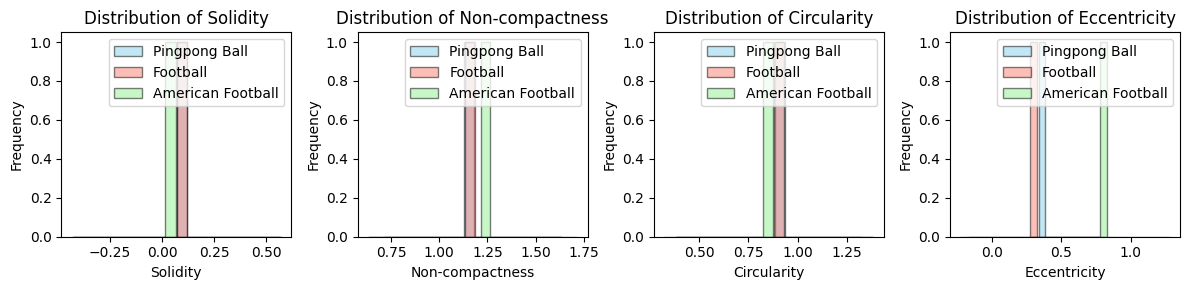

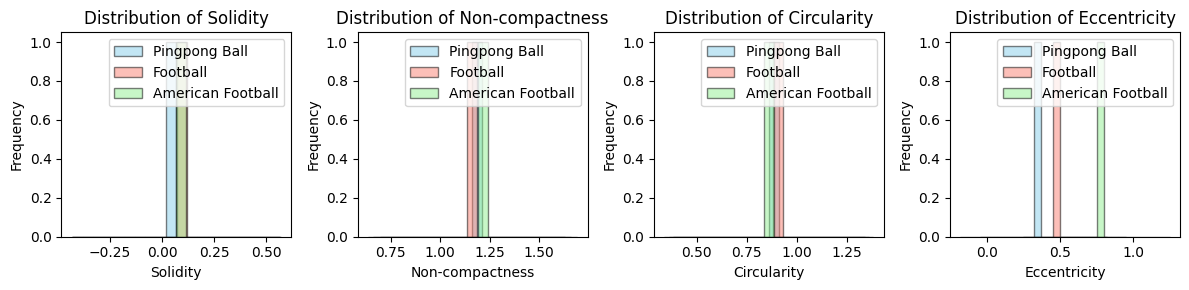

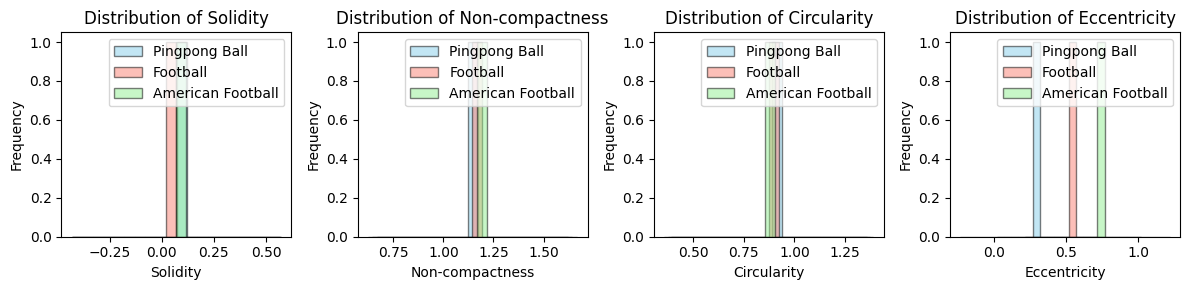

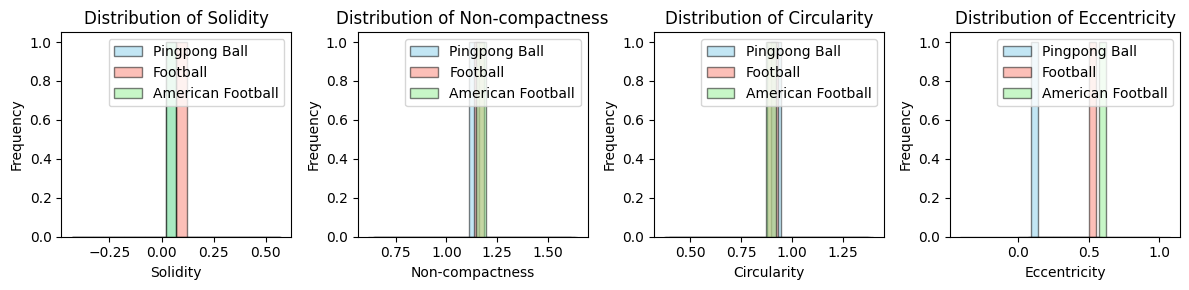

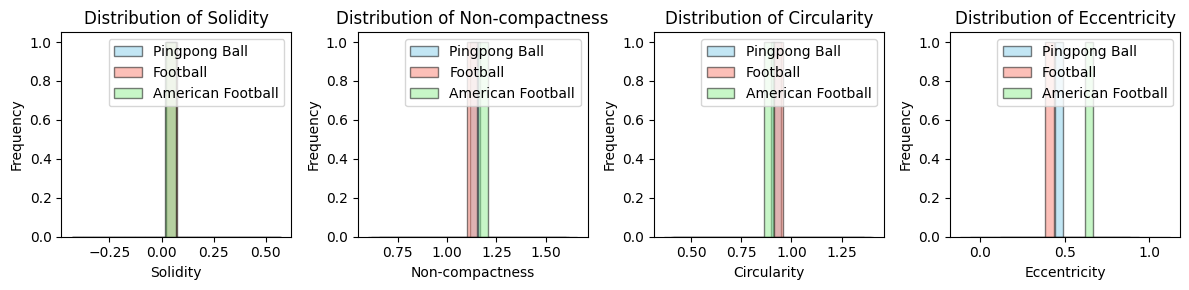

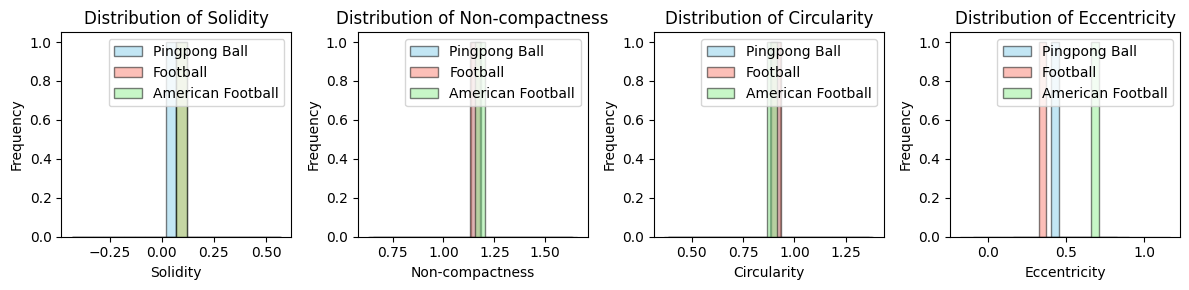

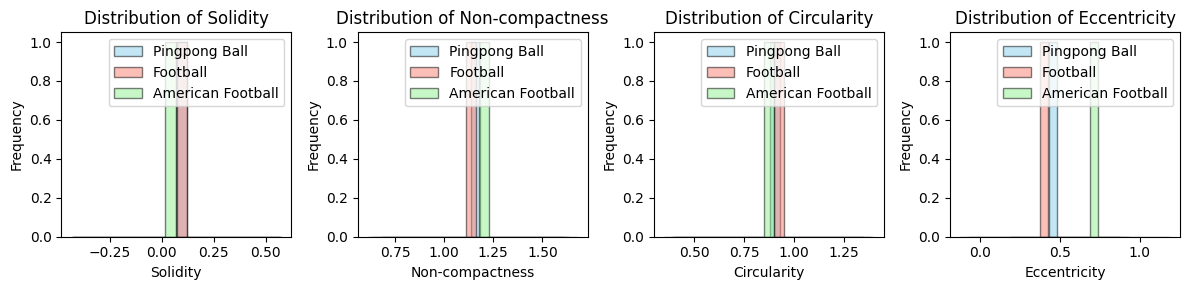

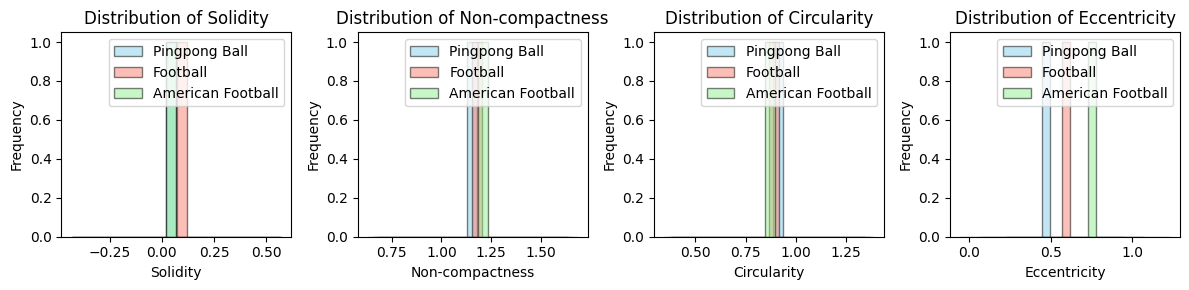

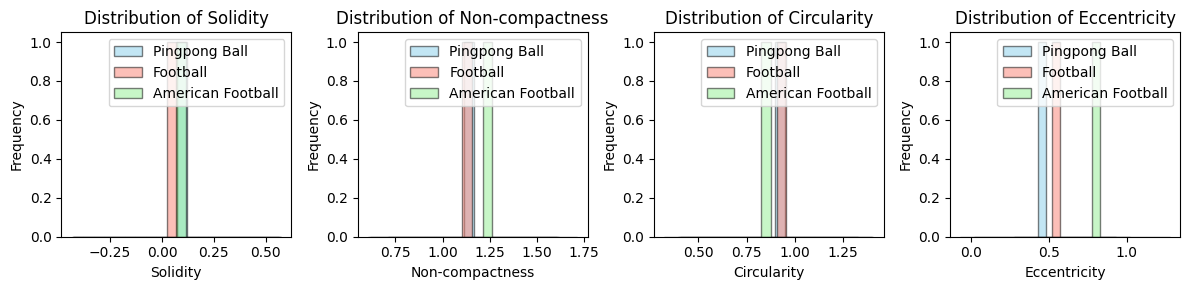

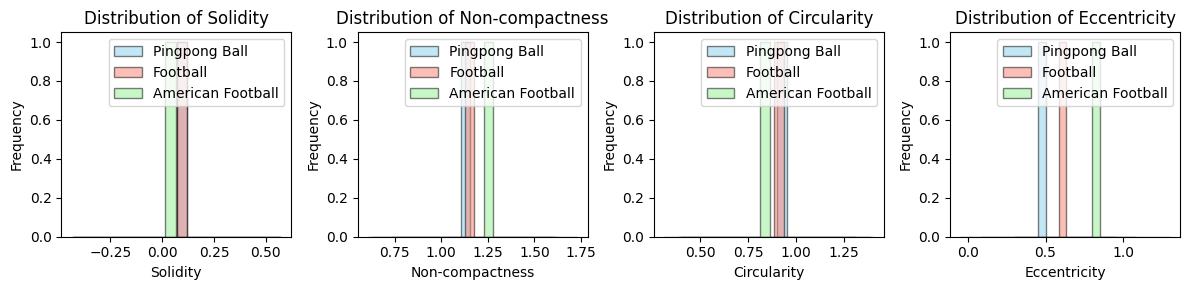

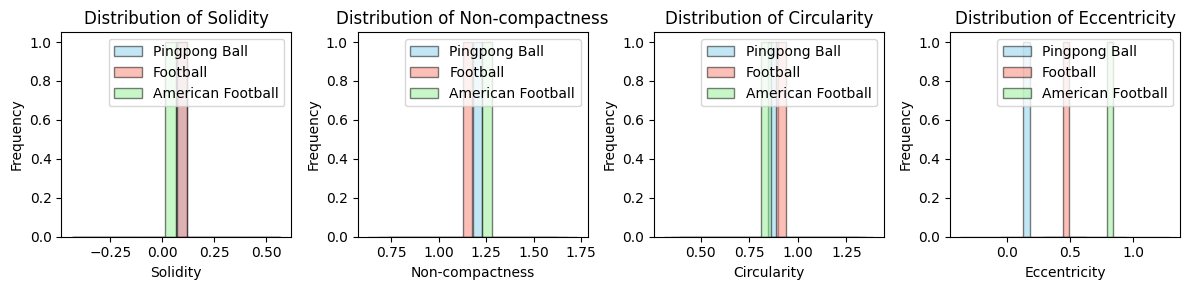

In [ ]:
# Iterate over each image and corresponding mask
for rgb_image, gt_mask in zip(rgb_images, gt_masks):
    # Extract ball patch from RGB image using the mask
    ball_patch = cv2.bitwise_and(rgb_image, rgb_image, mask=gt_mask)

    # Convert mask to binary
    _, binary_mask = cv2.threshold(gt_mask, 128, 255, cv2.THRESH_BINARY)
    # Find contours in the binary mask and sort them based on area
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea)
    # Separate contours based on ball type (assuming there are three contours)
    pingpong_ball_contour = contours[0]
    football_contour = contours[1]
    american_football_contour = contours[2]

    # Calculate shape features for each ball type
    pingpong_solidity, pingpong_non_compactness, pingpong_circularity, pingpong_eccentricity = calculate_shape_features(pingpong_ball_contour)
    football_solidity, football_non_compactness, football_circularity, football_eccentricity = calculate_shape_features(football_contour)
    american_football_solidity, american_football_non_compactness, american_football_circularity, american_football_eccentricity = calculate_shape_features(american_football_contour)

    # Plot distribution of shape features for each ball type
    features_lists = [
        (pingpong_solidity, football_solidity, american_football_solidity),
        (pingpong_non_compactness, football_non_compactness, american_football_non_compactness),
        (pingpong_circularity, football_circularity, american_football_circularity),
        (pingpong_eccentricity, football_eccentricity, american_football_eccentricity)
    ]
    feature_names = ['Solidity', 'Non-compactness', 'Circularity', 'Eccentricity']
    ball_types = ['Pingpong Ball', 'Football', 'American Football']
    colors = ['skyblue', 'salmon', 'lightgreen']

    plt.figure(figsize=(12, 3))
    for i, features in enumerate(features_lists):
        plt.subplot(1, 4, i+1)
        for j, feature in enumerate(features):
            plt.hist(feature , bins=20, color=colors[j], edgecolor='black', alpha=0.5, label=ball_types[j])
        plt.xlabel(feature_names[i])
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature_names[i]}')
        plt.legend()
    plt.tight_layout()
    plt.show()


## B: Texture Features

In [ ]:
def calculate_texture_features(patch):
    # Calculate GLCM for each color channel and each orientation
    glcms = []
    for channel in range(patch.shape[2]):
        glcm_0 = graycomatrix(patch[:, :, channel], [1], [0], symmetric=True, normed=True)
        glcm_45 = graycomatrix(patch[:, :, channel], [1], [np.pi / 4], symmetric=True, normed=True)
        glcm_90 = graycomatrix(patch[:, :, channel], [1], [np.pi / 2], symmetric=True, normed=True)
        glcm_135 = graycomatrix(patch[:, :, channel], [1], [3 * np.pi / 4], symmetric=True, normed=True)
        glcms.extend([glcm_0, glcm_45, glcm_90, glcm_135])

    # Calculate Haralick features for each orientation
    haralick_features = []
    for glcm in glcms:
        haralick_features.append([
            graycoprops(glcm, 'ASM')[0, 0],
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0]
        ])

    # Calculate feature average and range across orientations
    haralick_features = np.array(haralick_features)
    feature_avg = np.mean(haralick_features, axis=0)
    feature_range = np.ptp(haralick_features, axis=0)

    return haralick_features,feature_avg, feature_range

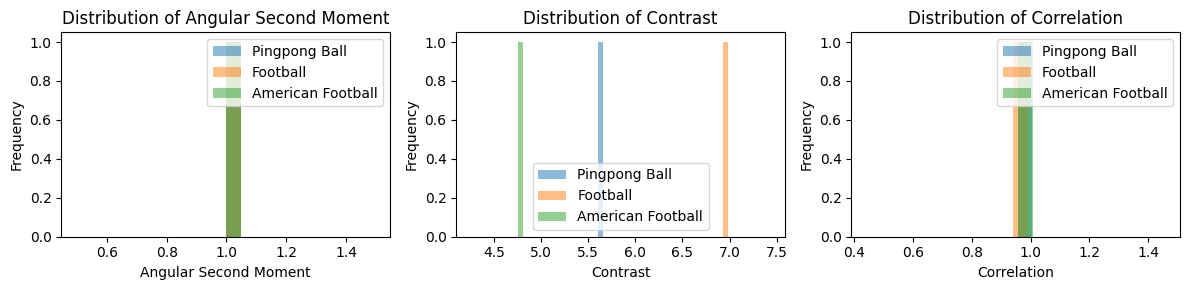

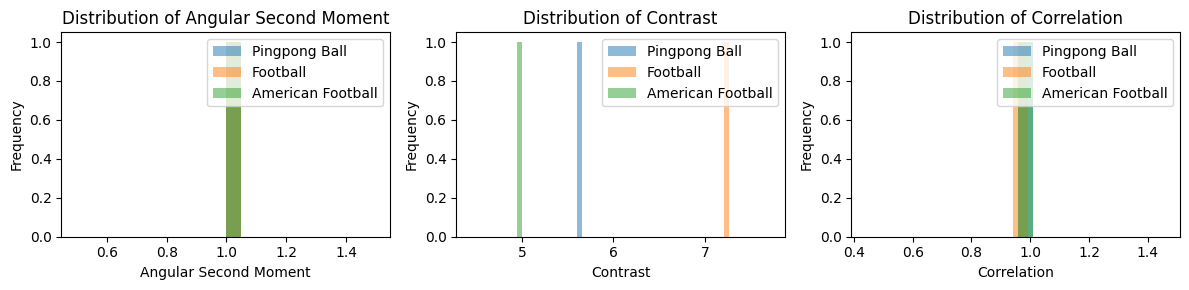

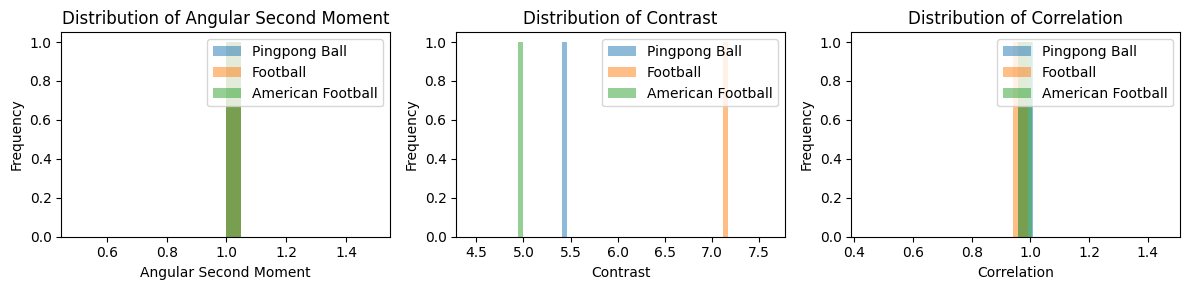

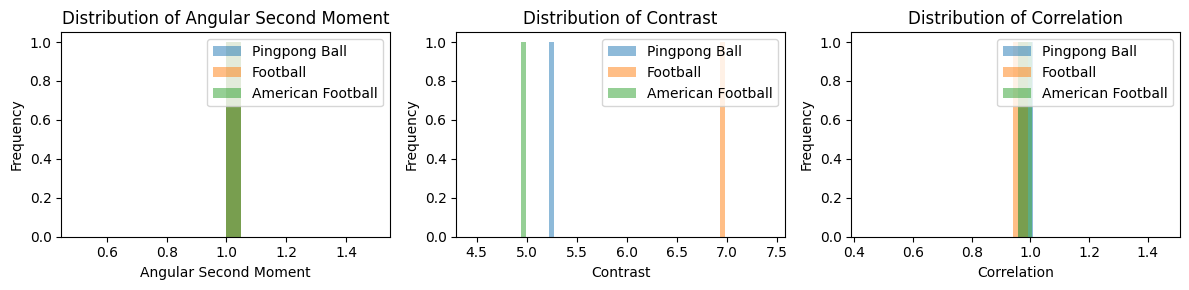

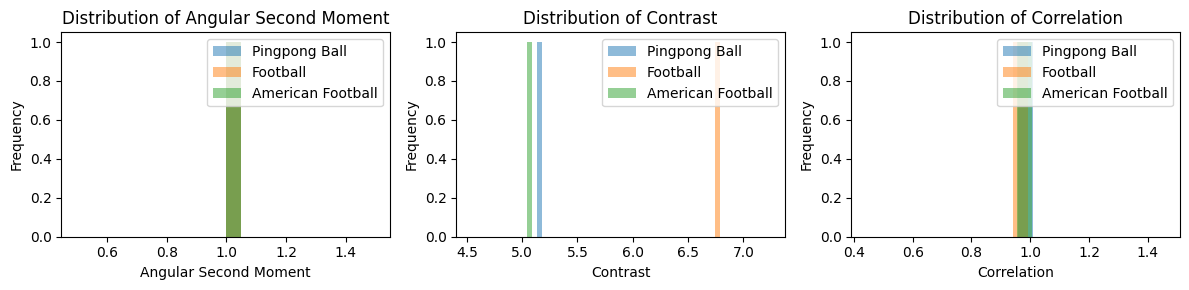

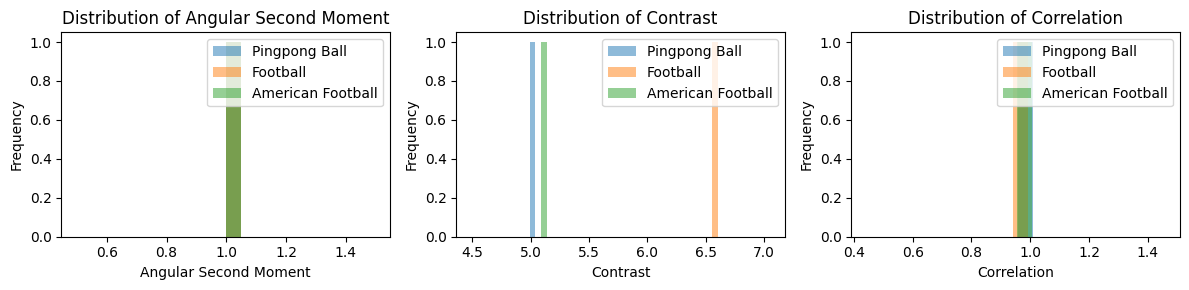

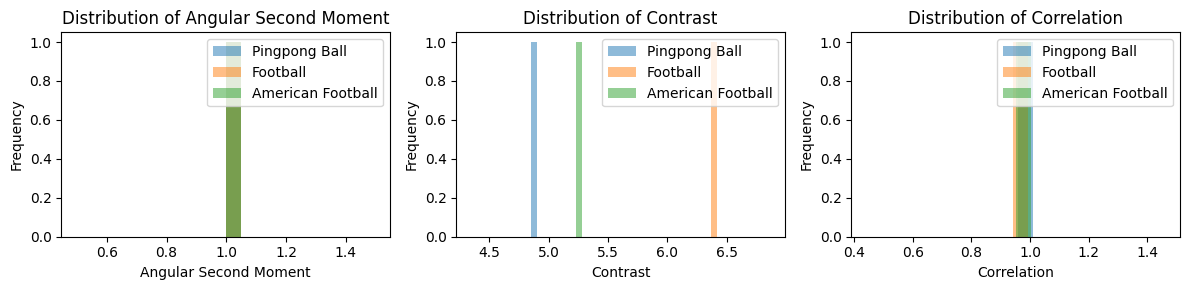

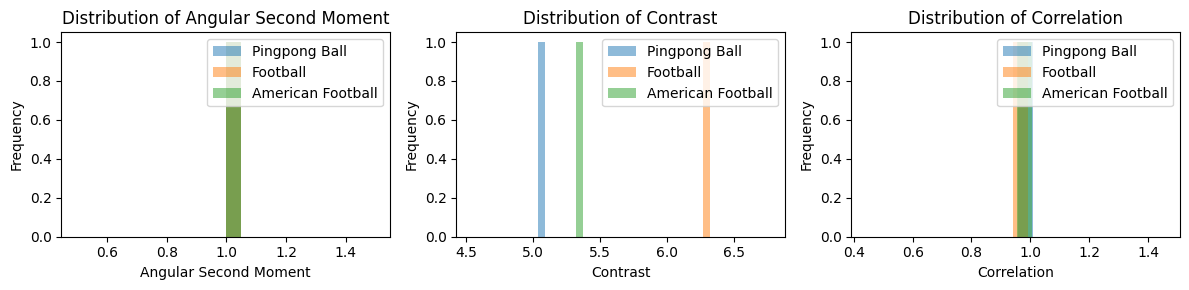

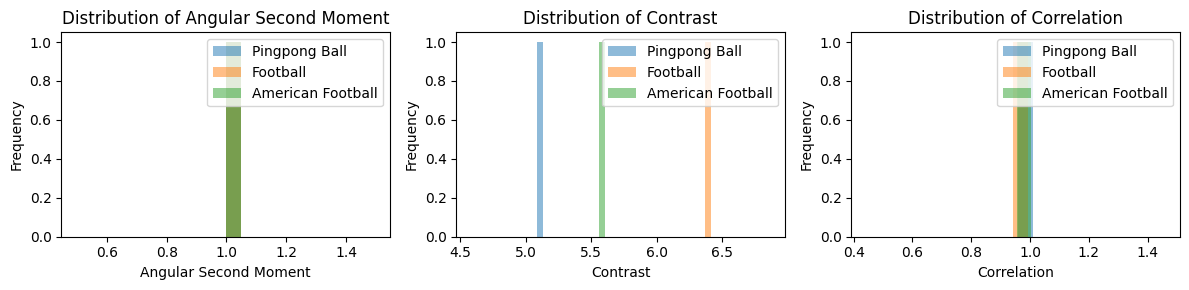

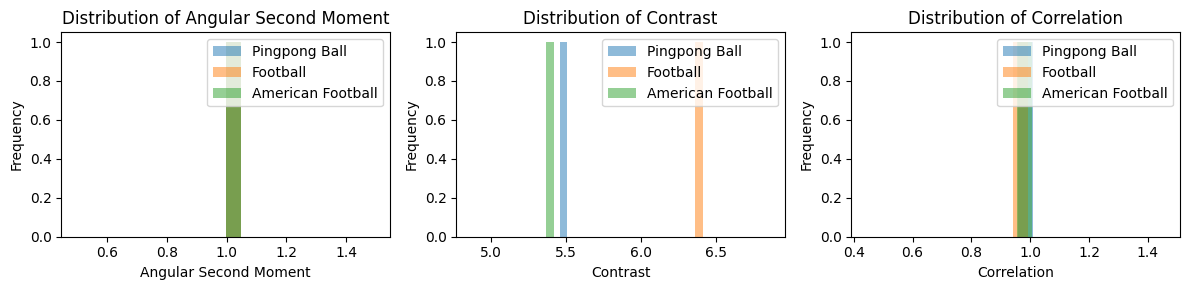

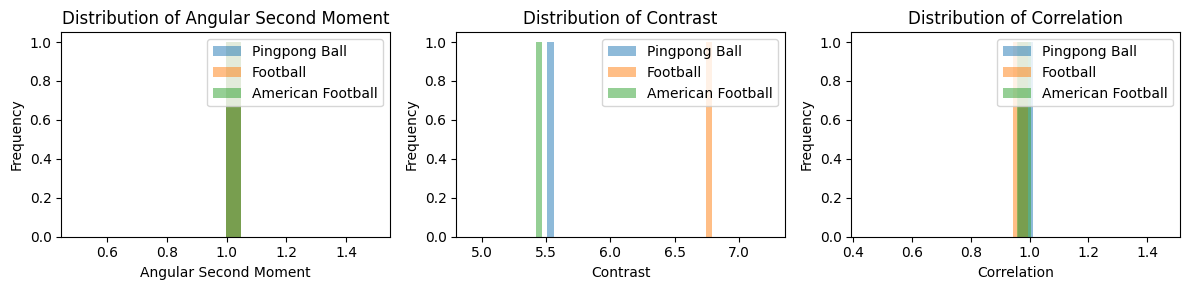

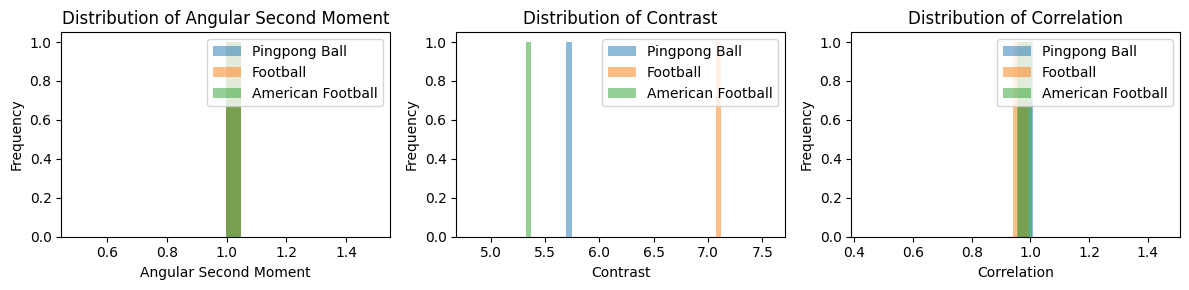

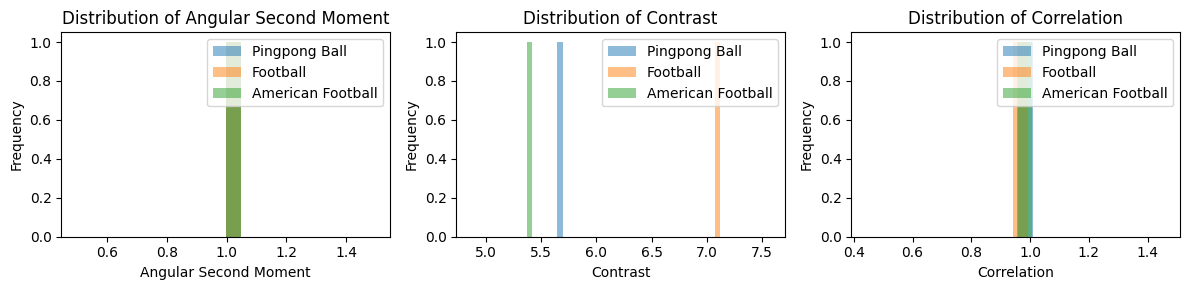

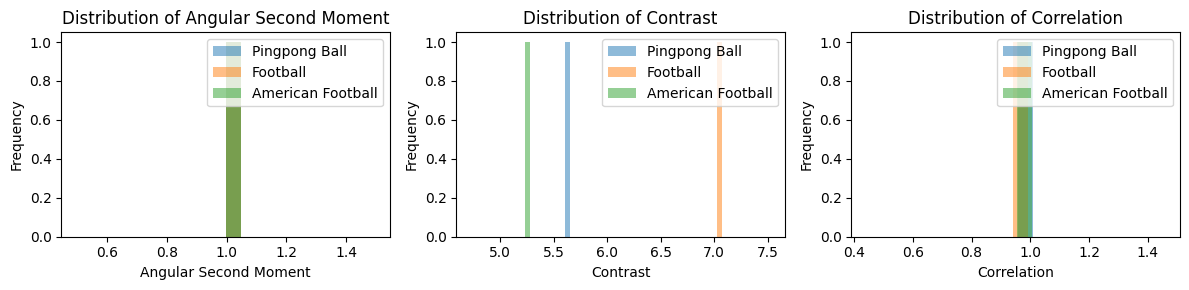

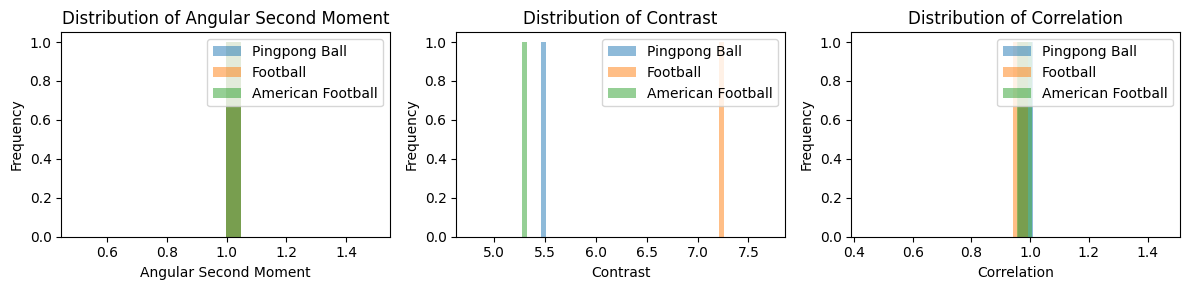

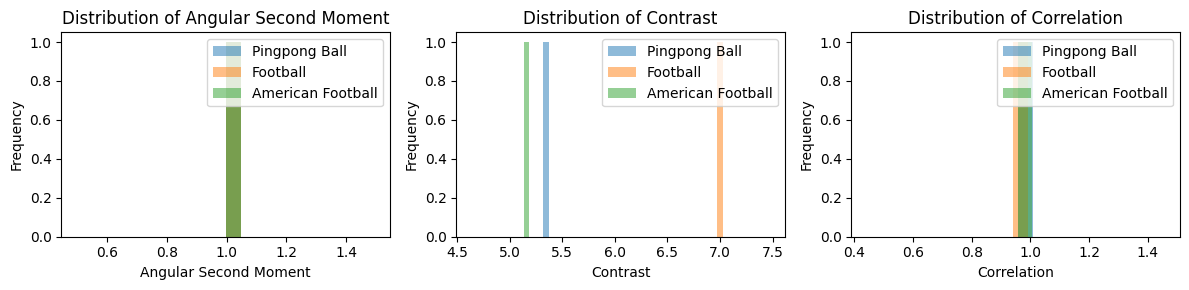

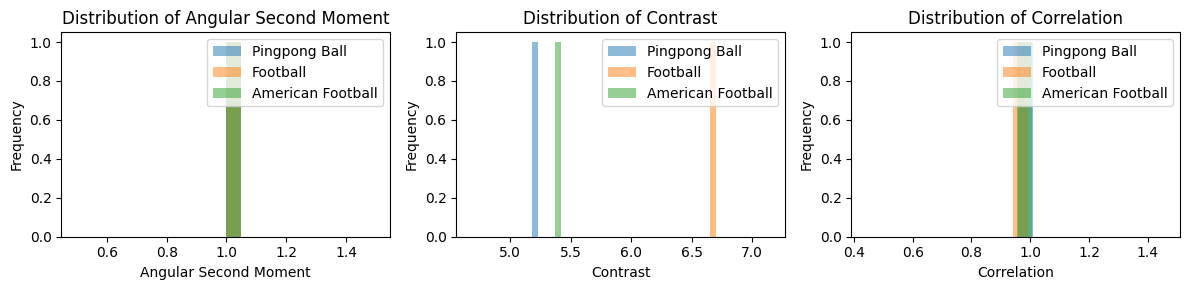

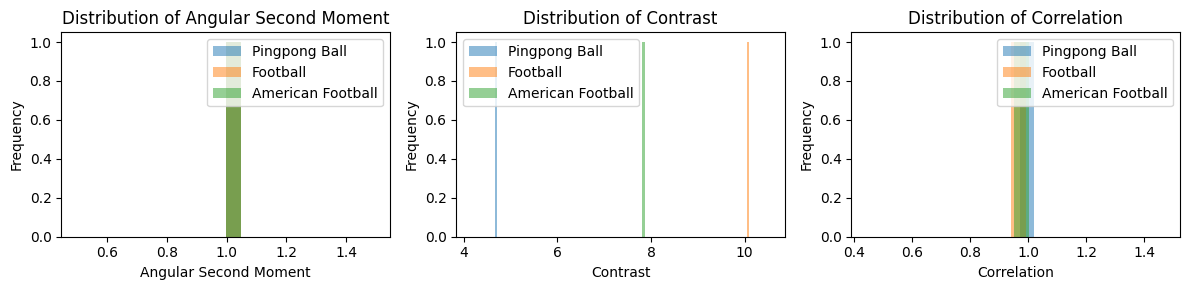

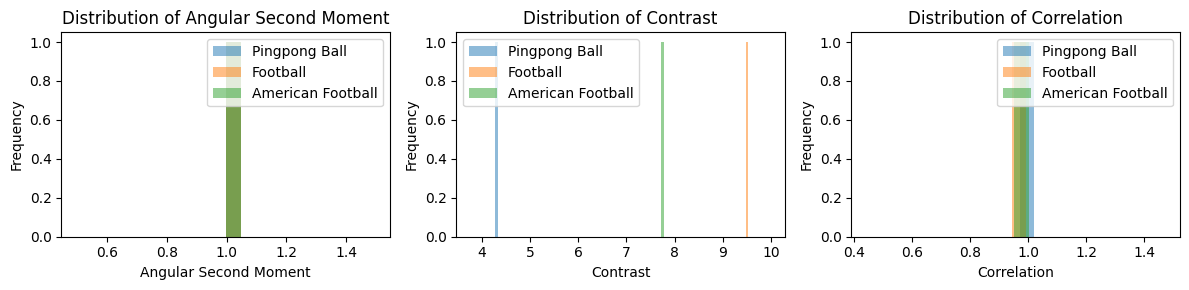

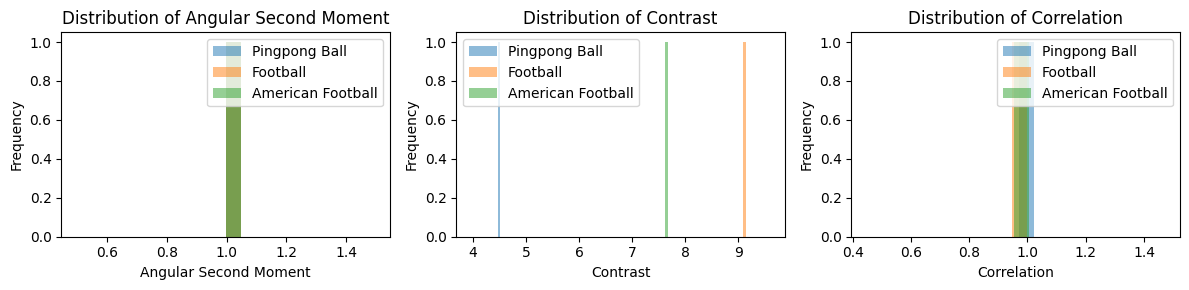

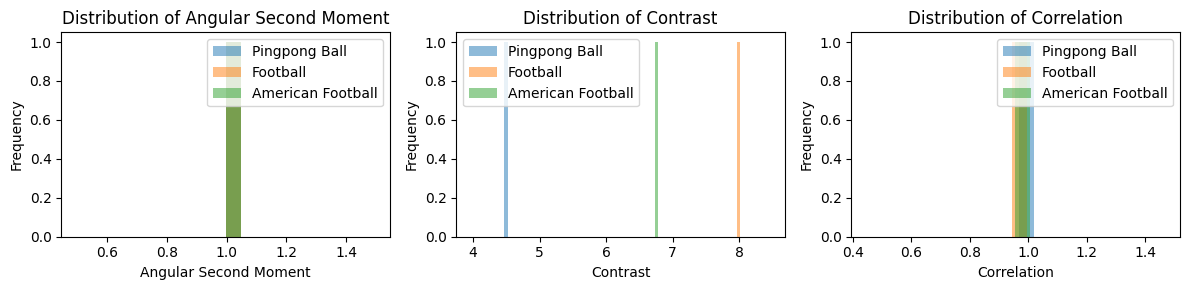

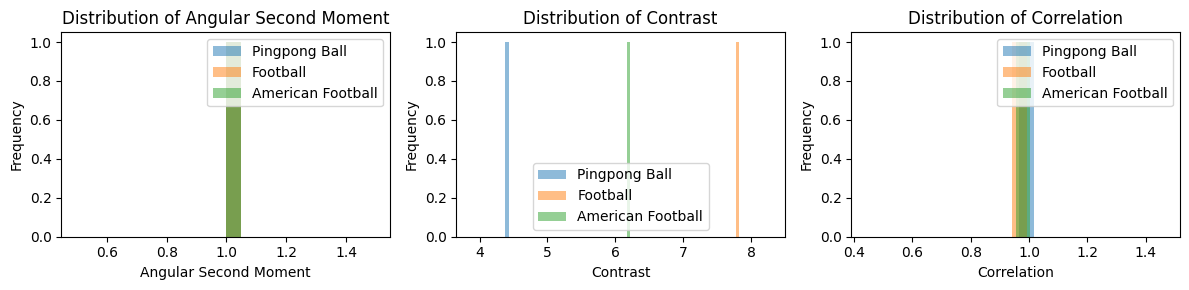

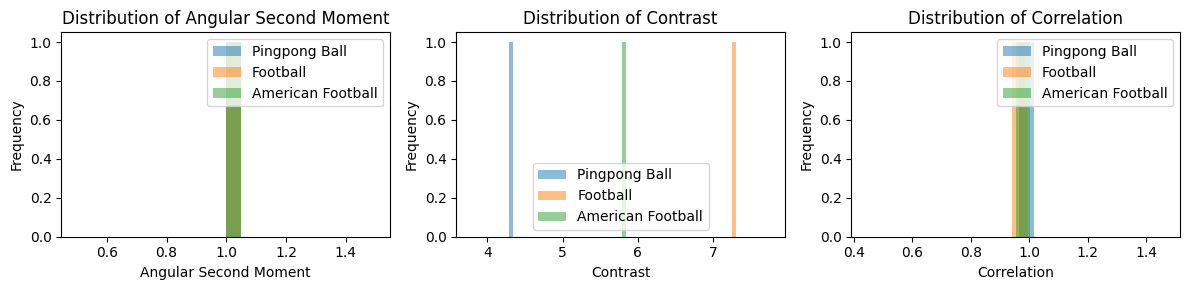

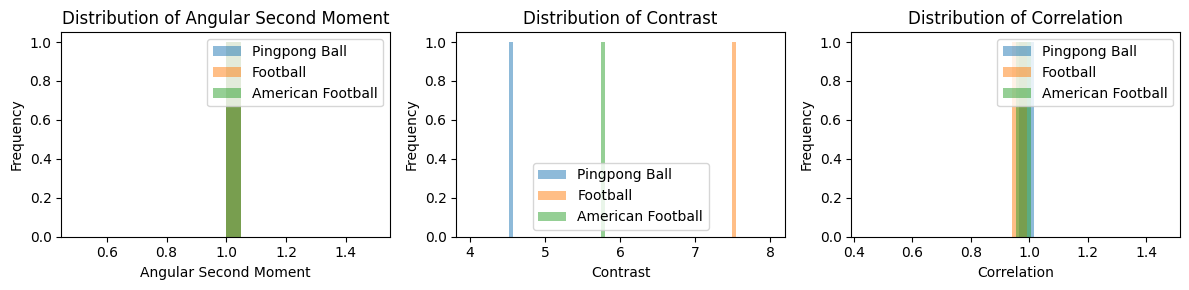

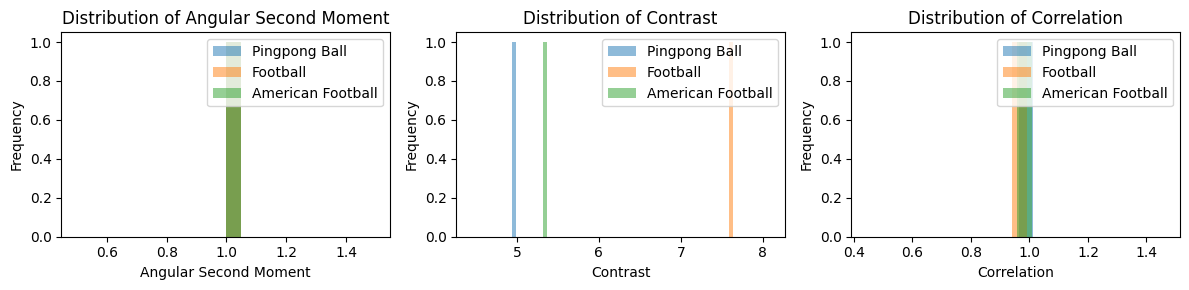

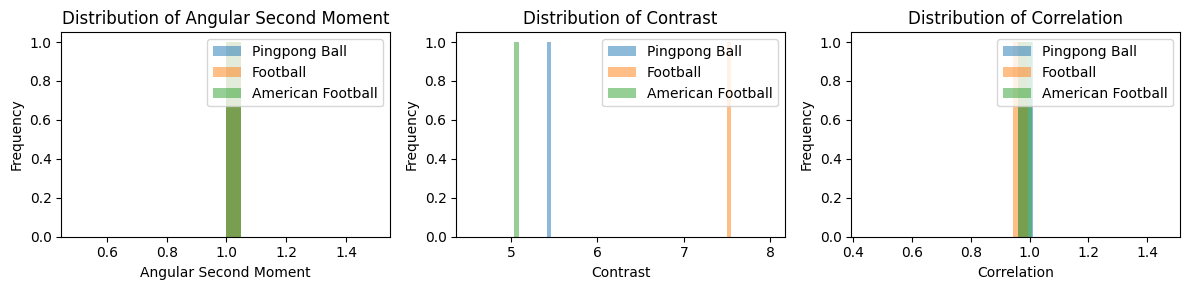

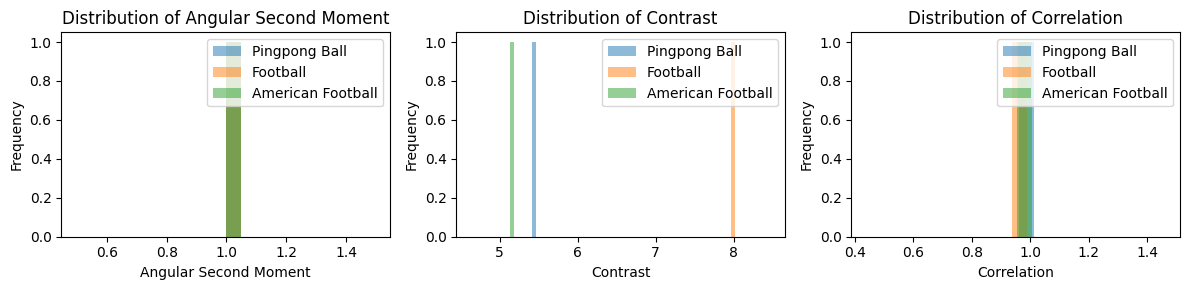

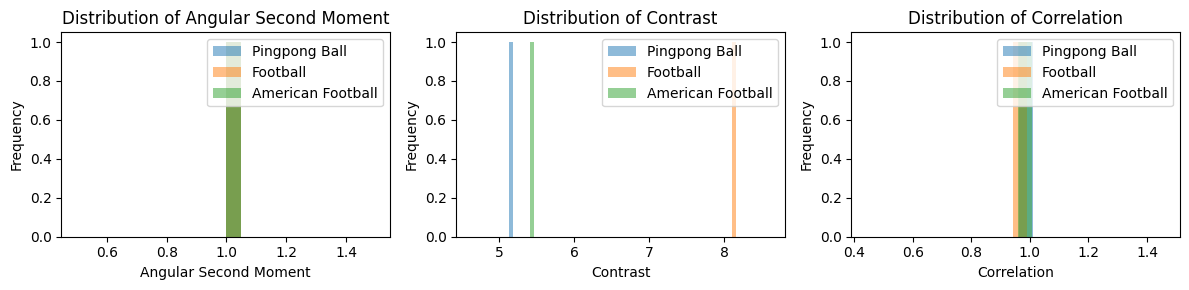

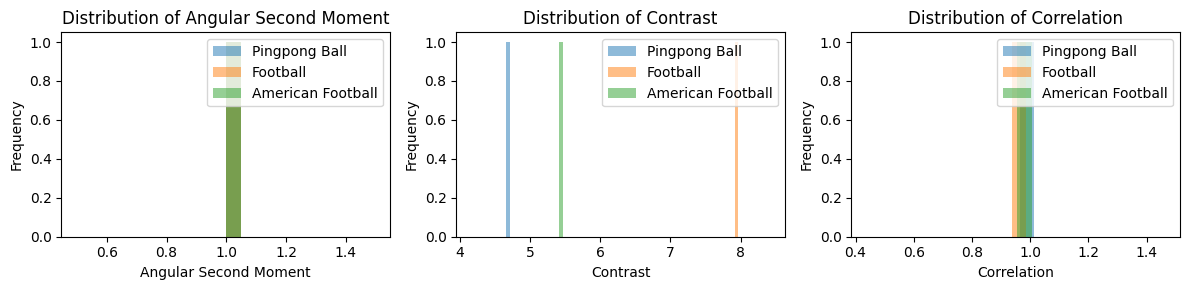

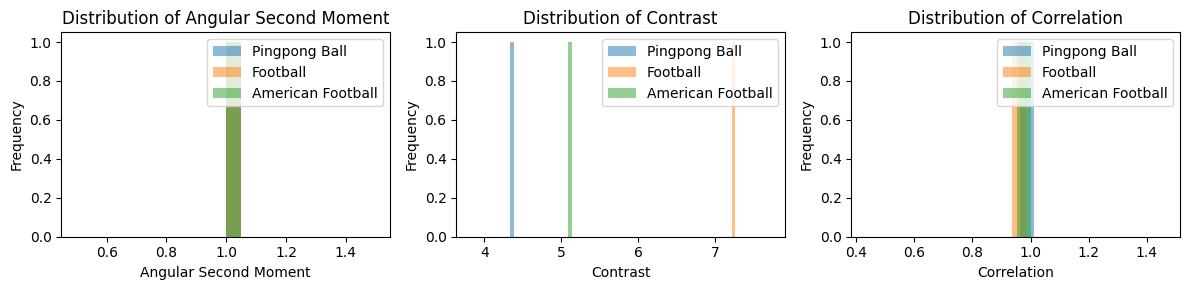

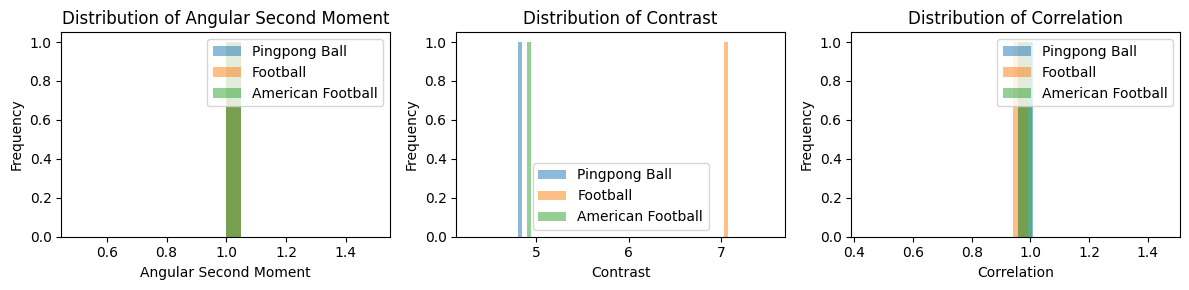

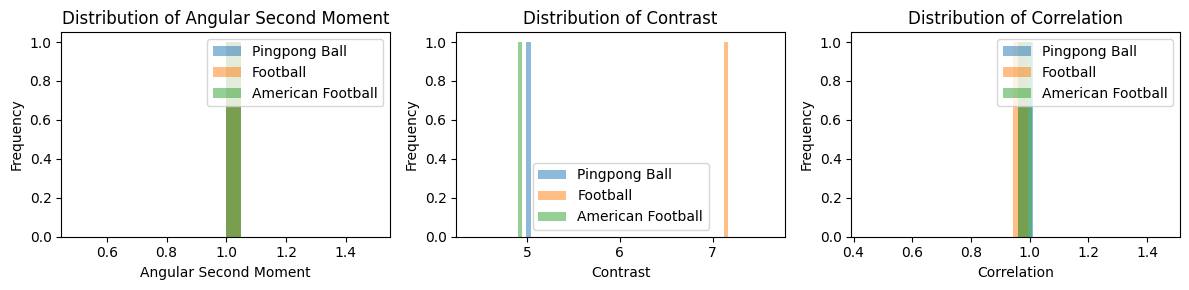

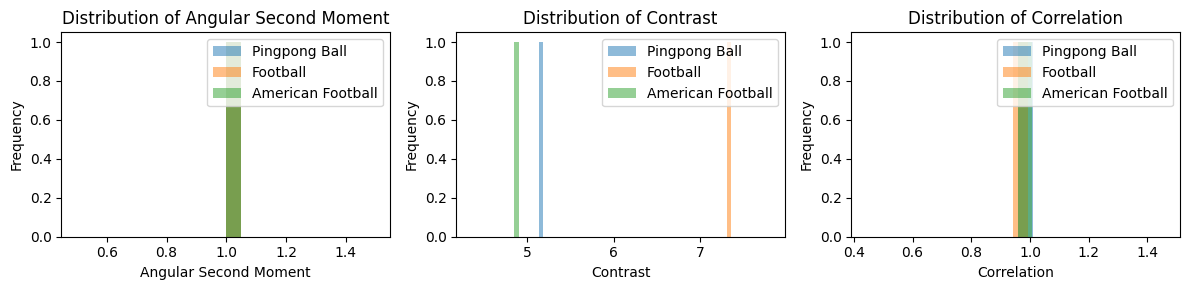

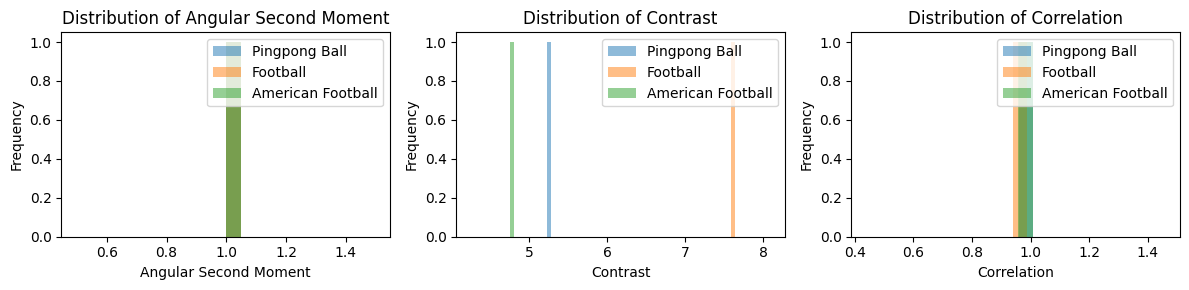

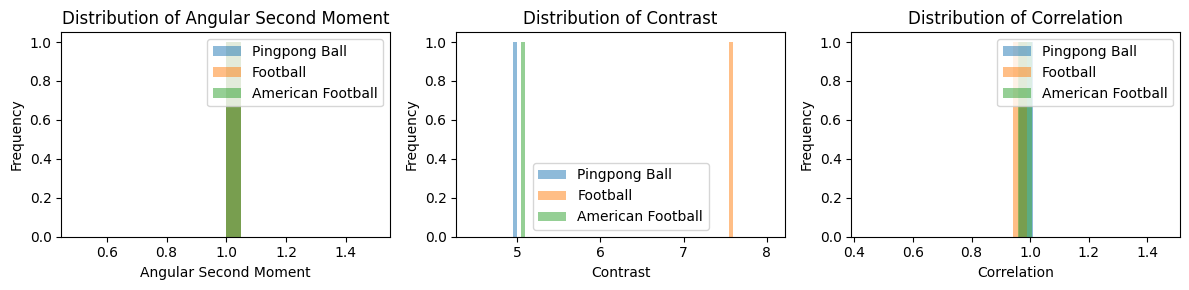

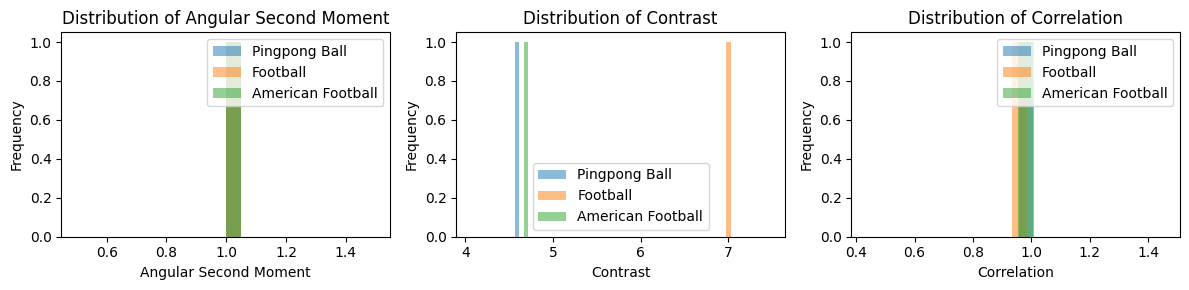

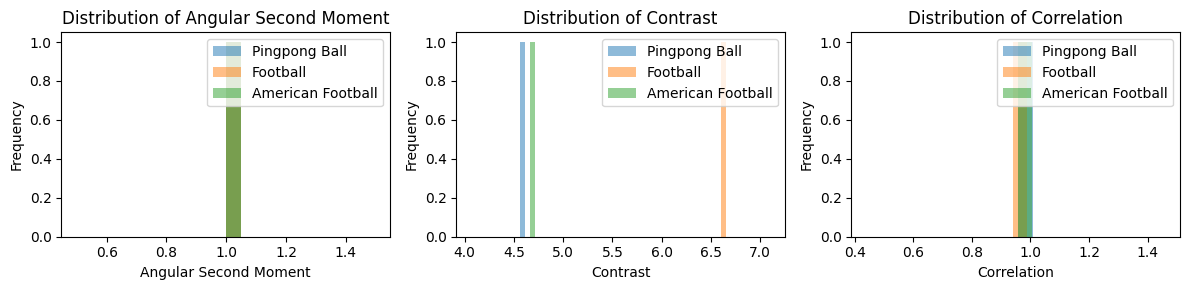

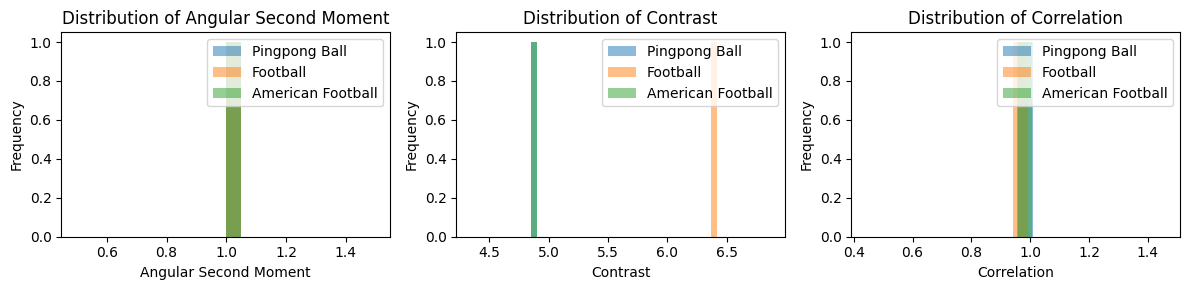

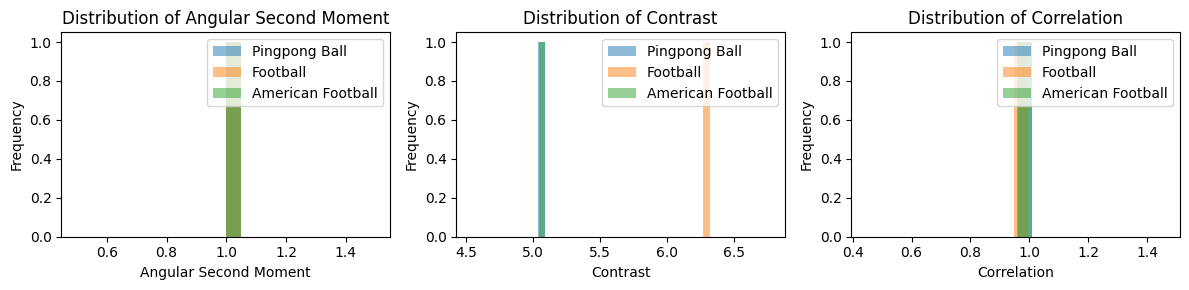

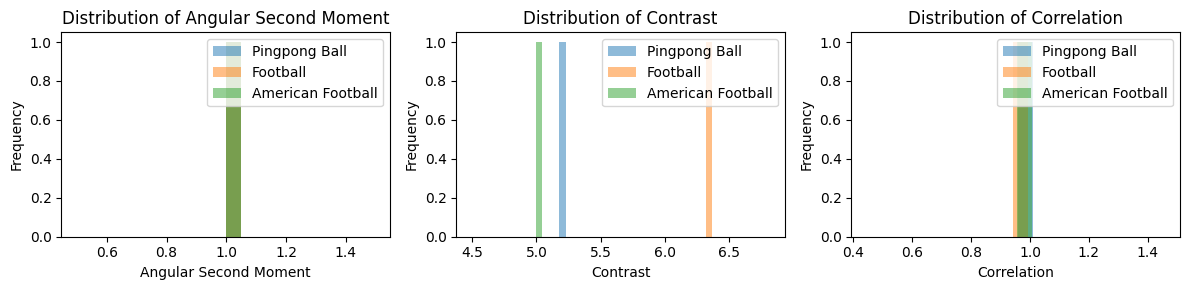

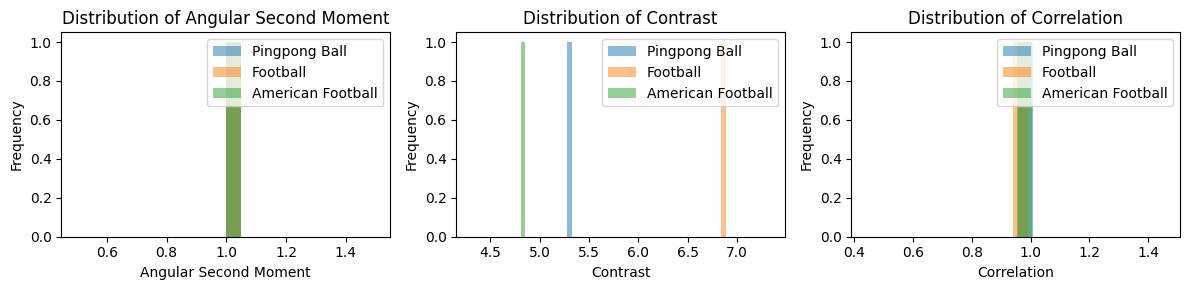

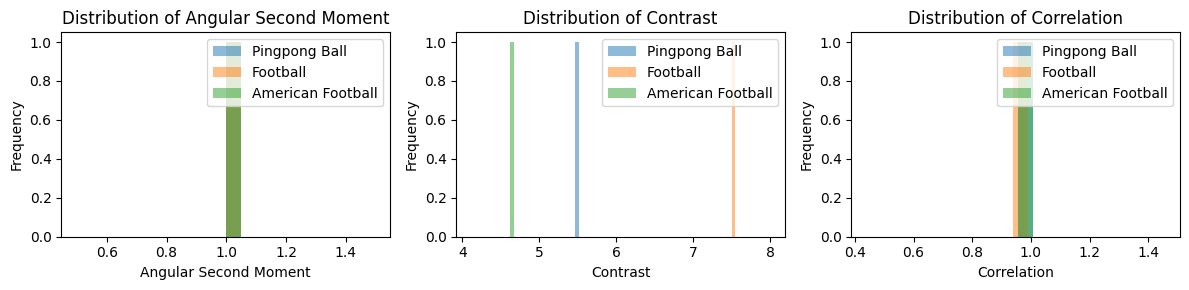

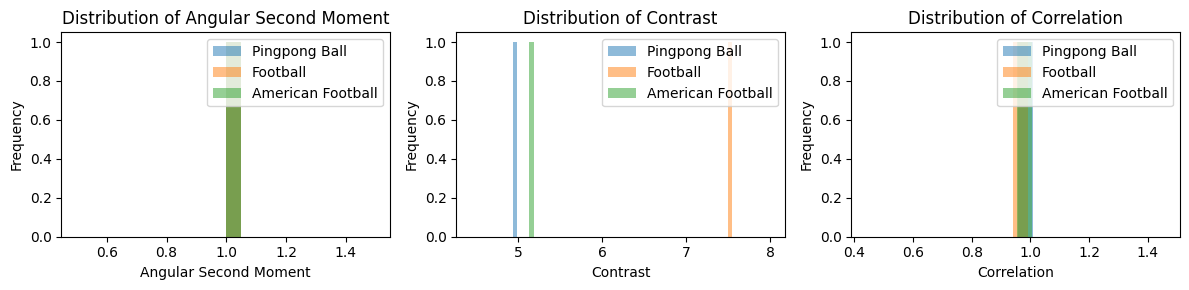

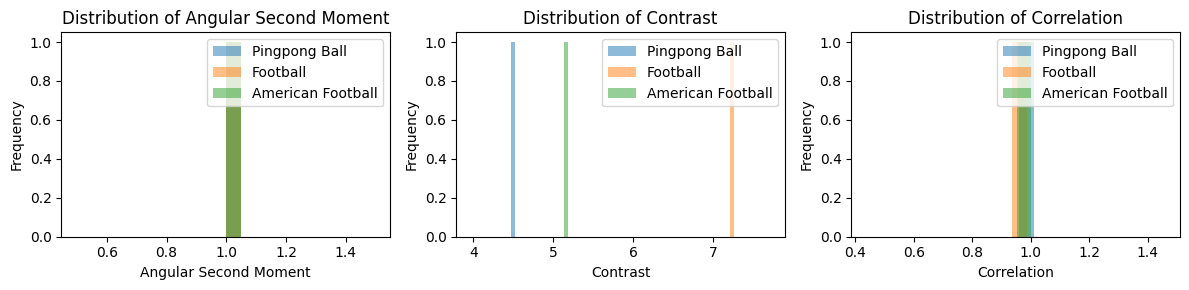

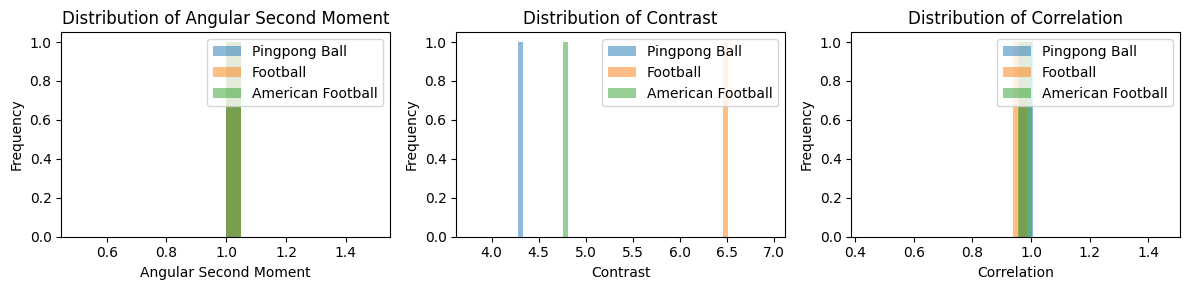

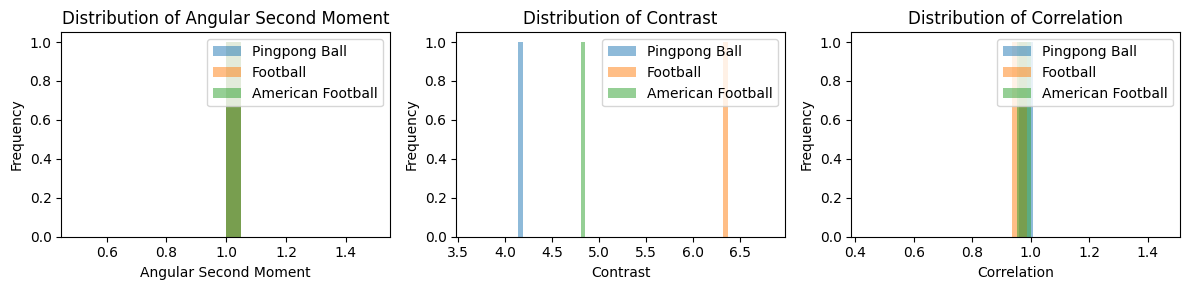

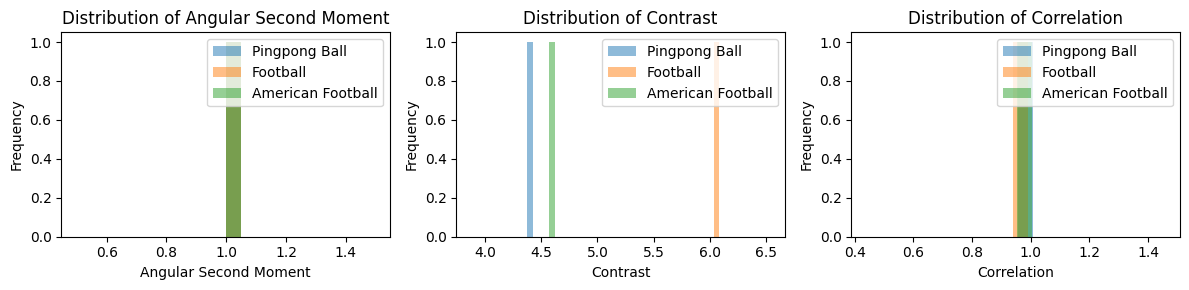

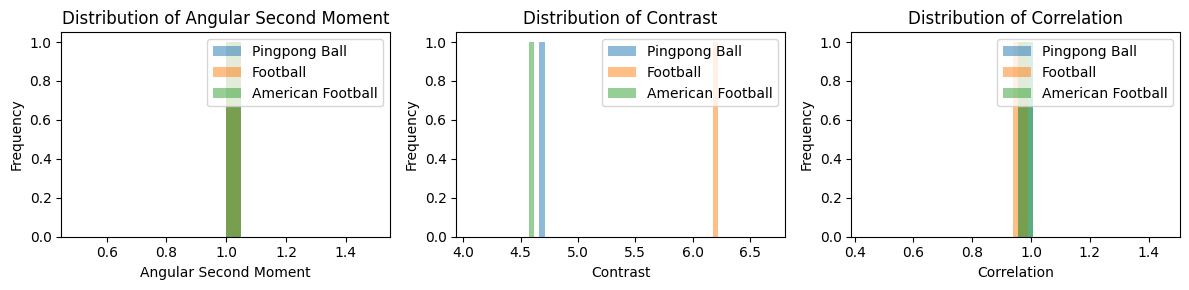

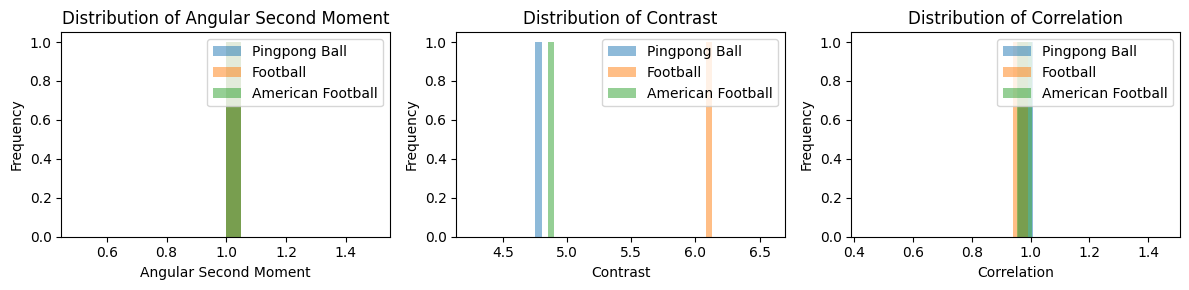

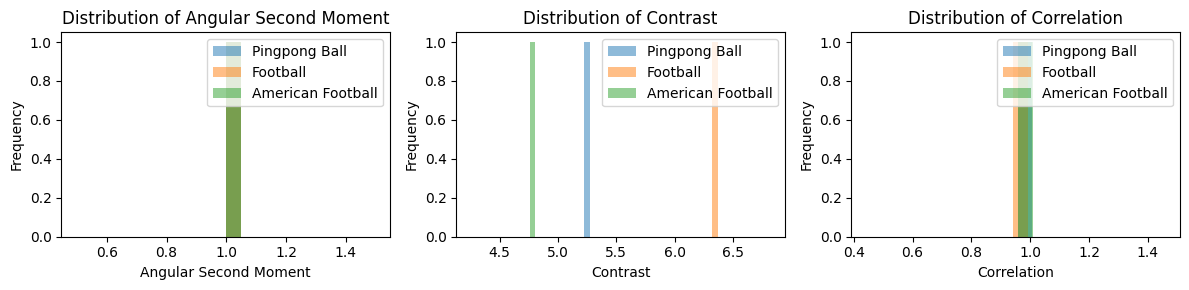

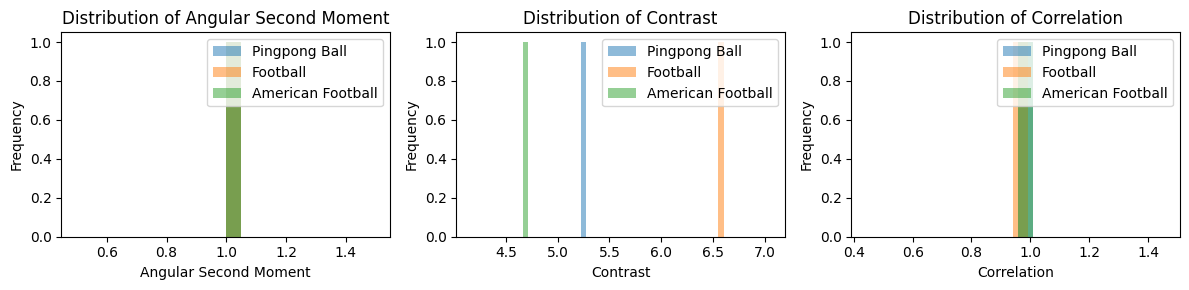

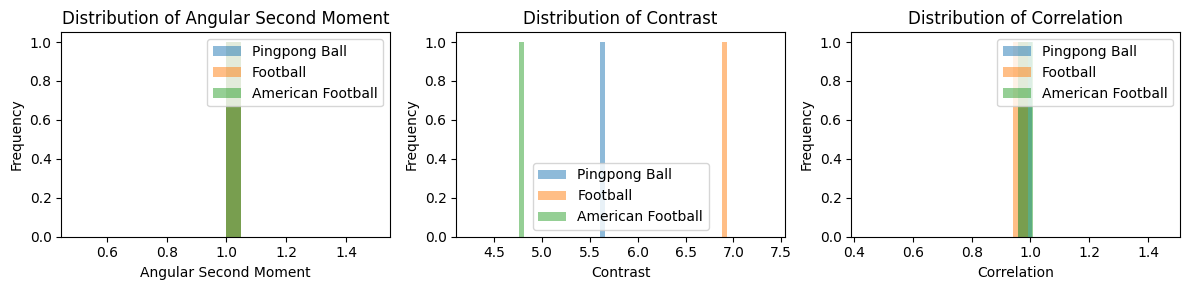

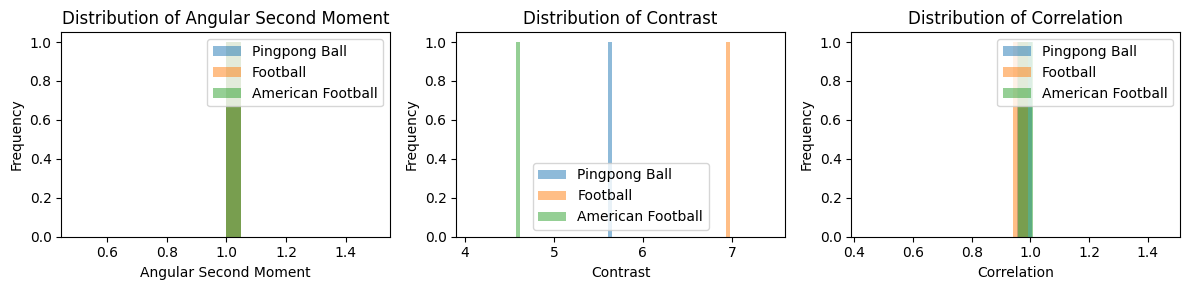

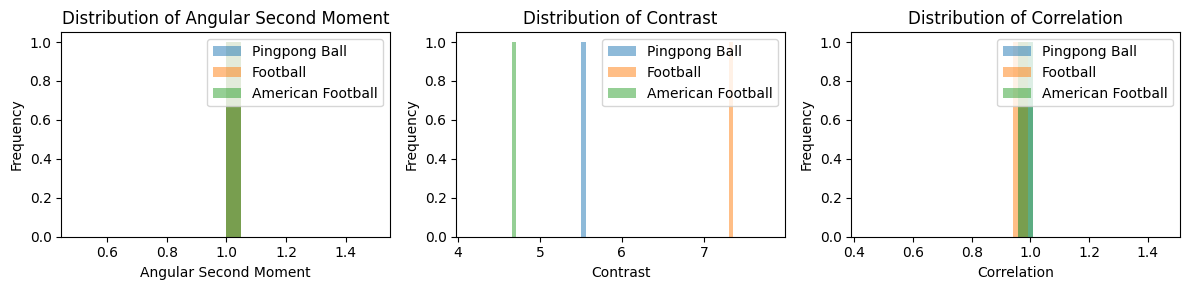

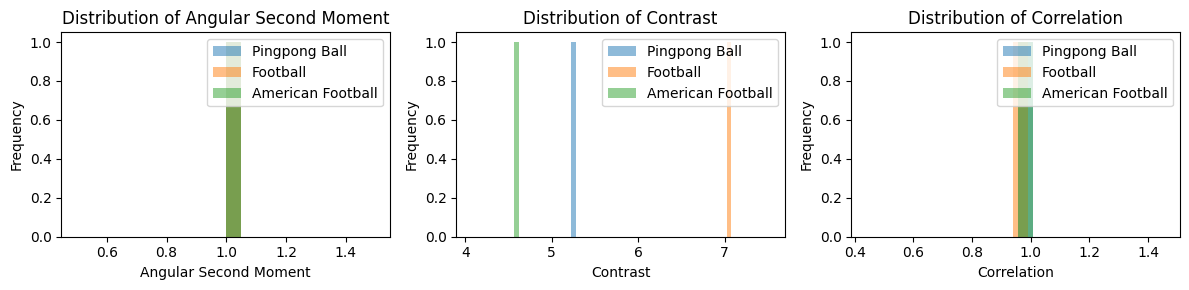

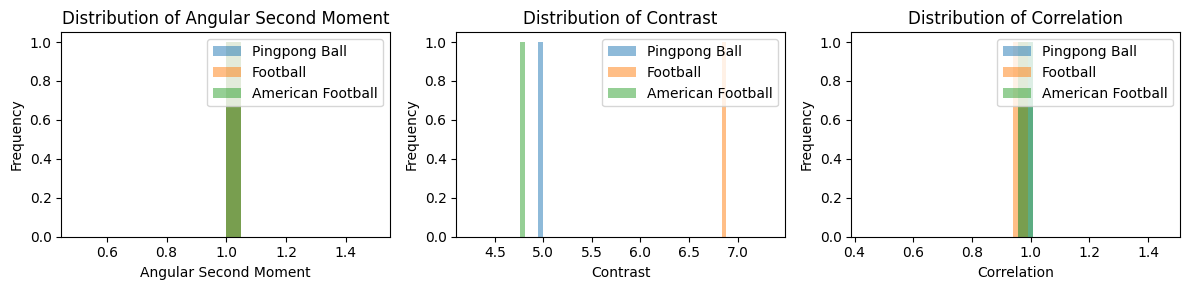

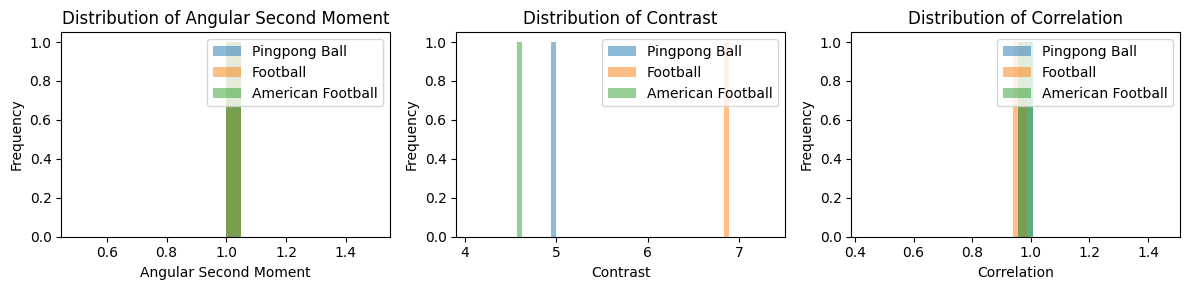

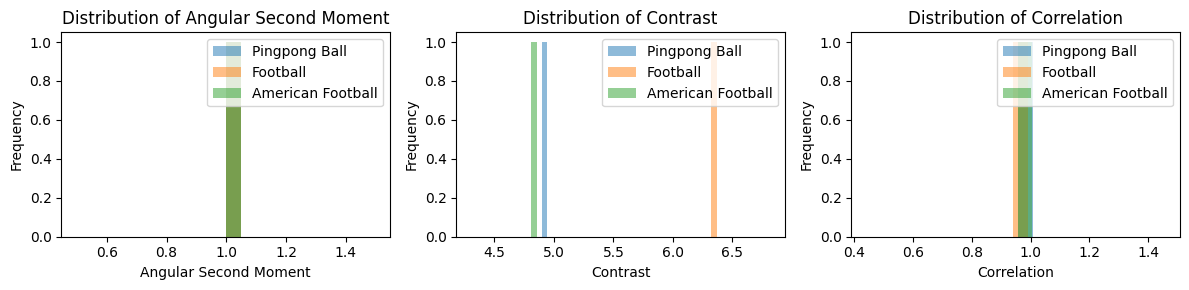

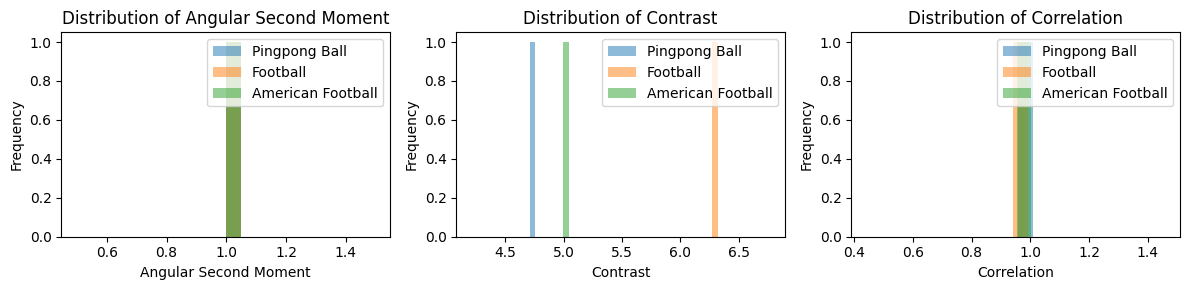

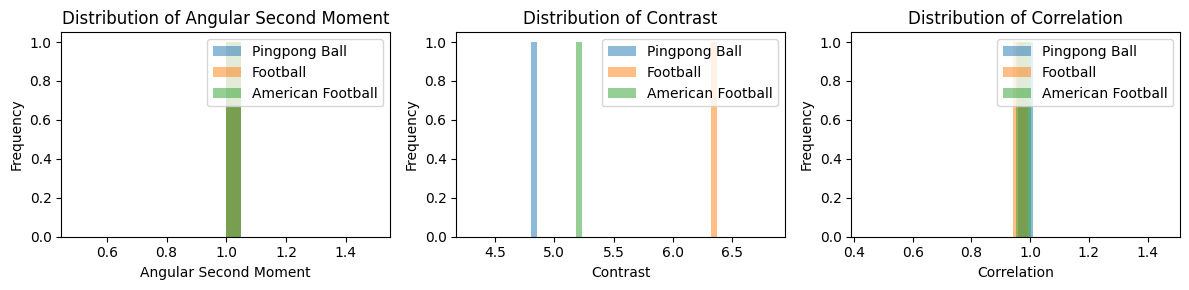

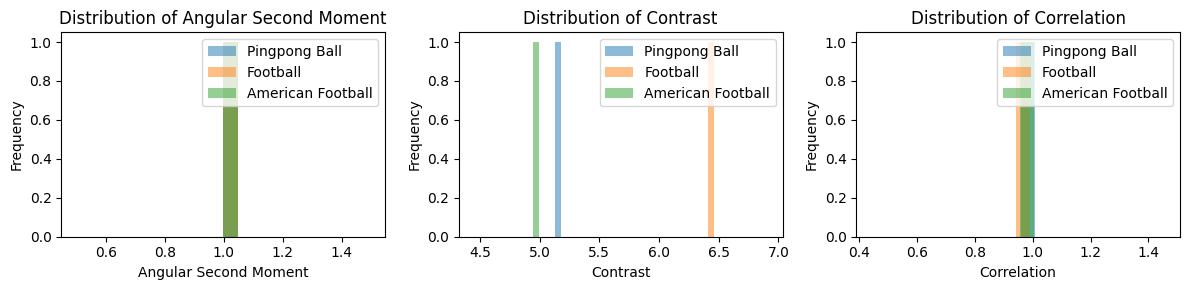

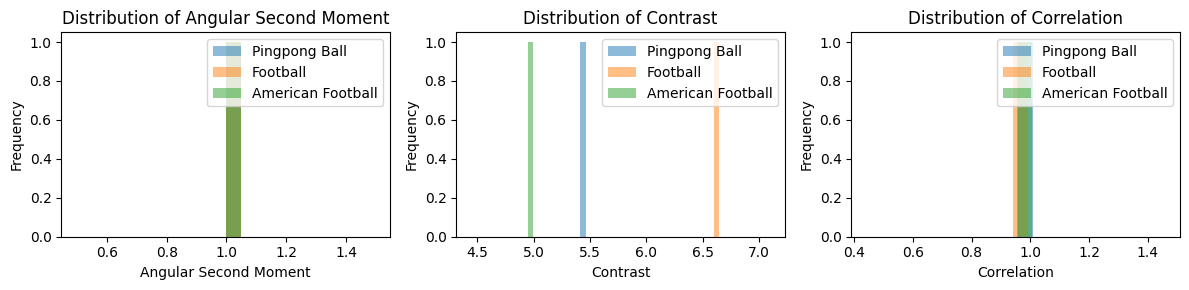

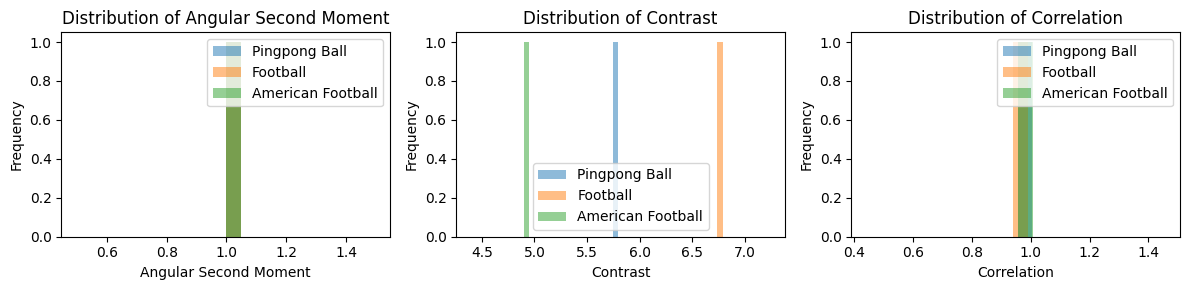

In [ ]:
# Iterate over each image and corresponding mask
for rgb_image, gt_mask in zip(rgb_images, gt_masks):

    contours, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Sort contours based on area
    contours = sorted(contours, key=cv2.contourArea)

    # Extract ball patches for each ball type using the contours
    pingpong_ball_patch = cv2.bitwise_and(rgb_image, rgb_image, mask=np.zeros_like(gt_mask))
    football_patch = cv2.bitwise_and(rgb_image, rgb_image, mask=np.zeros_like(gt_mask))
    american_football_patch = cv2.bitwise_and(rgb_image, rgb_image, mask=np.zeros_like(gt_mask))

    for i, contour in enumerate(contours):
        if i == 0:  # Smallest contour (pingpong ball)
            cv2.drawContours(pingpong_ball_patch, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
        elif i == 1:  # Second smallest contour (football)
            cv2.drawContours(football_patch, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
        elif i == 2:  # Largest contour (american football)
            cv2.drawContours(american_football_patch, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Calculate texture features for each ball type
    pingpong_features, pingpong_avg, pingpong_range = calculate_texture_features(pingpong_ball_patch)
    football_features, football_avg, football_range = calculate_texture_features(football_patch)
    american_football_features, american_football_avg, american_football_range = calculate_texture_features(american_football_patch)

    # Select one feature from each color channel
    # For example, let's select Angular Second Moment from each color channel
    selected_features = [
        (pingpong_features[:, 0] + football_features[:, 0] + american_football_features[:, 0]) / 3,  # ASM average
        (pingpong_features[:, 1] + football_features[:, 1] + american_football_features[:, 1]) / 3,  # Contrast average
        (pingpong_features[:, 2] + football_features[:, 2] + american_football_features[:, 2]) / 3,  # Correlation average
    ]

    # Plot distribution per ball type for selected features
    feature_names = ['Angular Second Moment', 'Contrast', 'Correlation']
    ball_types = ['Pingpong Ball', 'Football', 'American Football']

    plt.figure(figsize=(12, 3))
    for i, feature in enumerate(selected_features):
        plt.subplot(1, 3, i+1)
        for j in range(3):  # Loop over ball types
            plt.hist(feature[j], bins=20, alpha=0.5, label=ball_types[j])
        plt.xlabel(feature_names[i])
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {feature_names[i]}')
        plt.legend()
    plt.tight_layout()
    plt.show()


## Task 3: Object Tracking

In [ ]:
# Load data
x = pd.read_csv('/content/drive/MyDrive/ball_frames/x.csv', header=None)
y = pd.read_csv('/content/drive/MyDrive/ball_frames/y.csv', header=None)
na = pd.read_csv('/content/drive/MyDrive/ball_frames/na.csv', header=None)
nb = pd.read_csv('/content/drive/MyDrive/ball_frames/nb.csv', header=None)

# Extract actual data values
x_data = x.iloc[0, :]
y_data = y.iloc[0, :]
na_data = na.iloc[0, :]
nb_data = nb.iloc[0, :]


In [ ]:
# Constants and Matrices Initialization
dt = 0.5
F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
Q = np.array([[0.16, 0, 0, 0], [0, 0.36, 0, 0], [0, 0, 0.16, 0], [0, 0, 0, 0.36]])
R = np.array([[0.25, 0], [0, 0.25]])
# Adjusted starting estimate of the state
x_hat = np.array([na_data[0],(na_data[1] - na_data[0]) / dt, nb_data[0], (nb_data[1] - nb_data[0]) / dt])

# Adjusted initial covariance estimate, increase uncertainty in velocity
P = np.array([[10 , 0, 0, 0], [0, 10, 0, 0], [0, 0, 10, 0], [0, 0, 0, 10]])

# Simulation of the Kalman Filter
n = len(na_data)  # Number of measurements
estimates = []

for i in range(n):
    z = np.array([na_data[i], nb_data[i]])
    x_hat = F.dot(x_hat)
    P = F.dot(P).dot(F.T) + Q
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H.T).dot(np.linalg.inv(S))
    y = z - H.dot(x_hat)
    x_hat = x_hat + K.dot(y)
    P = (np.eye(4) - K.dot(H)).dot(P)
    estimates.append([x_hat[0], x_hat[2]])
    print(f"Iteration {i}:\nActual", "[", na_data[i], nb_data[i], "]")
    print(f"Estimate {[x_hat[0], x_hat[2]]}")

estimates = np.array(estimates)

Iteration 0:
Actual [ 41.308 482.0221 ]
Estimate [41.933596436870644, 481.7649001549187]
Iteration 1:
Actual [ 73.6138 468.7403 ]
Estimate [73.12126679766905, 468.9427939016127]
Iteration 2:
Actual [ 109.8999 461.1242 ]
Estimate [108.87837828693715, 460.39386360635103]
Iteration 3:
Actual [ 140.5836 470.7078 ]
Estimate [140.94979609995298, 466.271074293529]
Iteration 4:
Actual [ 165.9243 457.6026 ]
Estimate [167.83343427398344, 459.02983148852064]
Iteration 5:
Actual [ 189.537 454.676 ]
Estimate [191.72467752826148, 454.5892764759945]
Iteration 6:
Actual [ 211.7003 459.2286 ]
Estimate [213.67738151456624, 456.849301915378]
Iteration 7:
Actual [ 244.1291 449.8779 ]
Estimate [242.79750045404998, 451.22275845160965]
Iteration 8:
Actual [ 275.7434 457.0359 ]
Estimate [274.17266154473407, 454.66426450131036]
Iteration 9:
Actual [ 284.2376 457.06 ]
Estimate [289.06418218694546, 456.29586315571345]
Iteration 10:
Actual [ 317.1304 444.9809 ]
Estimate [315.828207467566, 447.99616370599296]
Iter

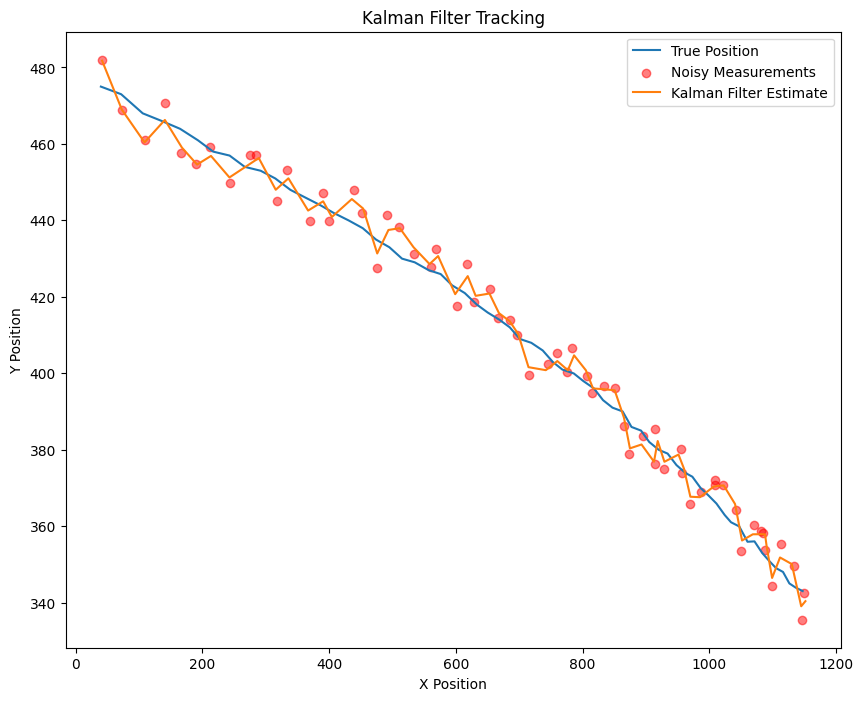

RMSE: [4.24384904 4.01797206]


In [ ]:
# Plotting
plt.figure(figsize=(10, 8))
plt.plot(x_data, y_data, label='True Position')
plt.scatter(na_data, nb_data, color='red', label='Noisy Measurements', alpha=0.5)
plt.plot(estimates[:, 0], estimates[:, 1], label='Kalman Filter Estimate')
plt.title('Kalman Filter Tracking')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

# Calculate RMSE
true_positions = np.column_stack((x_data, y_data))
rmse = np.sqrt(np.mean((estimates - true_positions)**2, axis=0))
print(f"RMSE: {rmse}")
